In [1]:
# importing packages !
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from tqdm import tqdm
import corner
import time
from collections import Counter
from matplotlib.ticker import MaxNLocator
import pickle as pickle
from scipy.optimize import minimize
from obspy.signal.rotate import rotate_ne_rt
from TransCFunctionsAlex import *

from obspy.clients.syngine import Client
client = Client()

from pyTransC import TransC_Sampler

import obspy
import pandas as pd
from datetime import datetime
from obspy.geodetics import gps2dist_azimuth
from obspy import Stream
#import UTCDateTime

from obspy.clients.fdsn import Client
ap = Client('IRIS')

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

# setting global parameter controls
plotting = True      # Create some diagnostic displays of outputs
parallel = False     # Use parallel computation for sampling
autopseudo = True    # Use automatic generation of pseudo-prior function, as alternate to user specified Gaussian.
autothin = False     # Thin internally generated within state posterior ensembles by their auto-correlation 

In [2]:
# setting up the stations and the event
inv = ap.get_stations(network='*', station="BYRD,DNTW,HOWD,MECK,STEW,UNGL,UPTW,WHIT", level='response', channel='LHZ,LHN,LHE', starttime=obspy.UTCDateTime(2016,1,1,1),
                      endtime = obspy.UTCDateTime(2020,1,1,1), maxlatitude=-63)
print(inv)

sta_lats = []
sta_lons = []
for i in range(len(inv)):
    for j in range(len(inv[i])):
        sta_lats.append(inv[i][j].latitude)
        sta_lons.append(inv[i][j].longitude)

print('Number of stations:', len(sta_lats))

# indexing the stations to a single variable

stations_flat = []
networks_flat = []
for i in range(len(inv)):
    for j in range(len(inv[i])):
        stations_flat.append(inv[i][j].code)
        networks_flat.append(inv[i].code)

print((stations_flat))
print(len(networks_flat))

bulk_stations = []

for i in range(len(sta_lats)):
    receiver_lat = sta_lats[i]
    receiver_lon = sta_lons[i]
    station_code = stations_flat[i]
    bulk_stations.append({"latitude": receiver_lat, "longitude": receiver_lon, "stationcode": station_code})

#print(bulk_stations)

son = pd.read_csv(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\Pham2025_submitted\TableS1.csv")
#son = son[son['quality_group'] == 'A'] # filtering to only the quality A events

lats = son['relocated_latitude'].tolist()
lons = son['relocated_longitude'].tolist()

det_lats = son['detected_latitude'].tolist()
det_lons = son['detected_longitude'].tolist()

mags = son['Ms_BB'].tolist()
times = son['relocated_time'].tolist()
qual_group = son['quality_group'].tolist()
ens = son['eff_nstations'].tolist()

#qualities = son['quality_group'].tolist()

son_date_format = '%Y-%m-%dT%H:%M:%S.000000Z'

years = []
months = []
days = []
for i in range(len(times)):
    years.append(int(datetime.strptime(times[i], son_date_format).strftime('%Y')))
    months.append(int(datetime.strptime(times[i], son_date_format).strftime('%m')))
    days.append(int(datetime.strptime(times[i], son_date_format).strftime('%d')))
    
# calculate the distance between two stations
def distance(lat1, lon1, lat2, lon2):
    return gps2dist_azimuth(lat1, lon1, lat2, lon2)[0]

def back_azimuth(lat1, lon1, lat2, lon2):
    return gps2dist_azimuth(lat1, lon1, lat2, lon2)[2]

# isolating the specific event
test = []

for i in range(len(times)):
    if times[i] == '2018-11-08T05:03:34.000000Z':
        test.append(i)
        event_lat = lats[i]
        event_lon = lons[i]
        event_time = times[i]
        event_mag = mags[i]
        event_year = years[i] + months[i]/12 + days[i]/365

for i in range(len(bulk_stations)):
    distancee = distance(event_lat, event_lon, bulk_stations[i]['latitude'], bulk_stations[i]['longitude'])/1000
    print(bulk_stations[i]['stationcode'], distancee)
    backaz = back_azimuth(event_lat, event_lon, bulk_stations[i]['latitude'], bulk_stations[i]['longitude'])
    print(bulk_stations[i]['stationcode'], backaz)
    print('---')
    
event_info = event_lat, event_lon, event_time

station_infos = [sta_lats, sta_lons, networks_flat, stations_flat]

station_info = []

for i in range(len(sta_lats)):
    station_inf = inv, networks_flat[i], stations_flat[i], sta_lats[i], sta_lons[i] 
    station_info.append(station_inf)
    
stations = stations_flat

Inventory created at 2025-10-18T12:45:45.452900Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2016-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			YT
		Stations (8):
			YT.BYRD (BYRD)
			YT.DNTW (Lower Thwaites Glacier)
			YT.HOWD (Howard Nunatak)
			YT.MECK (MECK)
			YT.STEW (STEW)
			YT.UNGL (Union Glacier)
			YT.UPTW (UPTW)
			YT.WHIT (Whitmore Mountains)
		Channels (48):
			YT.BYRD..LHZ (3x), YT.BYRD..LHN (3x), YT.BYRD..LHE (3x), 
			YT.DNTW..LHZ (2x), YT.DNTW..LHN (2x), YT.DNTW..LHE (2x), 
			YT.HOWD..LHZ (2x), YT.HOWD..LHN (2x), YT.HOWD..LHE (2x), 
			YT.MECK..LHZ, YT.MECK..LHN, YT.MECK..LHE, YT.STEW..LHZ, 
			YT.STEW..LHN, YT.STEW..LHE, YT.UNGL..LHZ (2x), YT.UNGL..LHN (2x), 
			YT.UNGL..LHE (2x), YT.UPTW..LHZ (3x), YT.UPTW..LHN (3x), 
			YT.UPTW..LHE (3x), YT.WHIT..LHZ (2x), YT.WHIT..LHN (2x), 
			YT.WHIT..LHE (2x)
Number of stations: 8
['BYRD', 'DNTW', 'HOWD', 'MECK'

## Constructing the Correlated Noise Matrix of "Unrealistic" Correlated Noise

In [3]:
import pickle

with open(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\python\Syngine\TransCSepOct\stage2 - Copy\cdinv_real_multistation.pkl", "rb") as f:
    cdinv_real = pickle.load(f)
    
with open(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\python\Syngine\TransCSepOct\stage2 - Copy\cdset_real_multistation.pkl", "rb") as f:
    cdsets_real = pickle.load(f)

print(len(cdinv_real))
print(len(cdinv_real[0]))
print(len(cdinv_real[0][0]))
print(len(cdinv_real[0][0][0]))

data_len = 250
tt = np.linspace(0, data_len, data_len) # 1 Hz sampling rate

8
2
3
250


<Figure size 2400x600 with 0 Axes>

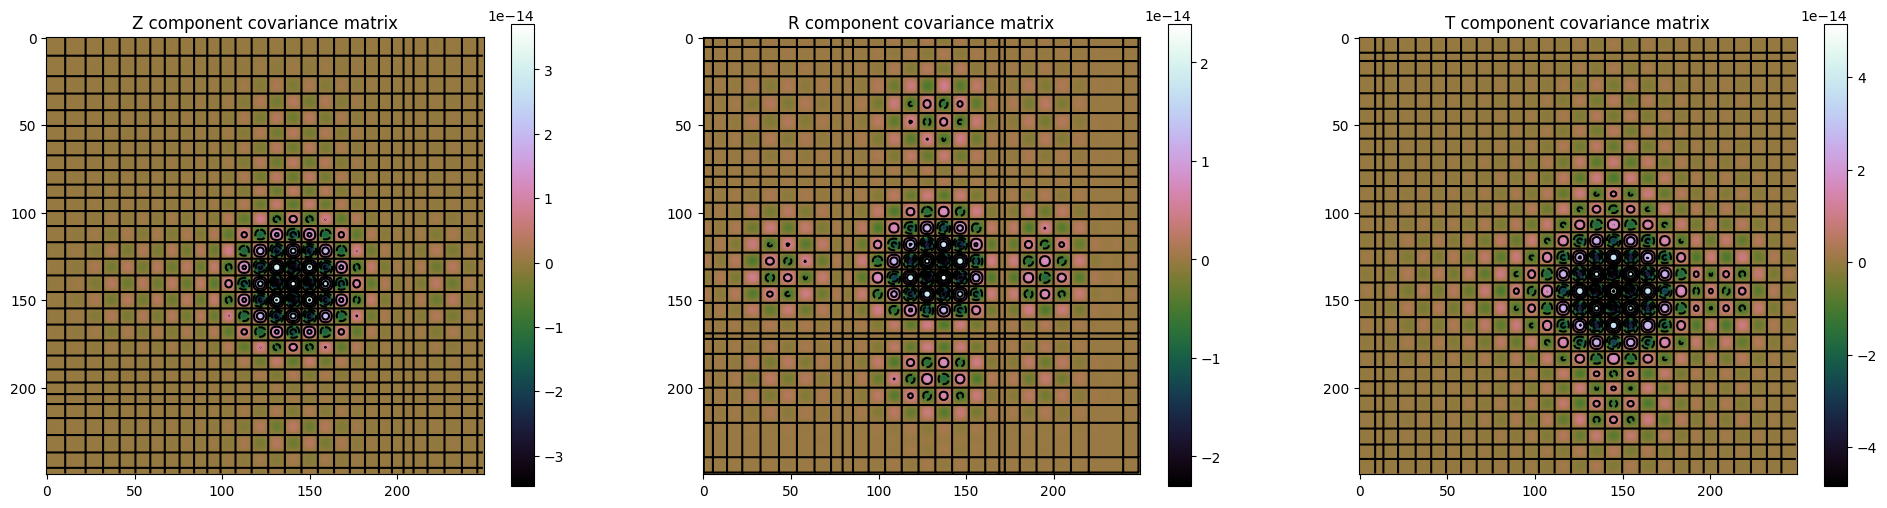

In [4]:
## showing the Covariance matrices
# C_ddz = np.linalg.inv(cdinv_real[0][0][0])
# C_ddr = np.linalg.inv(cdinv_real[0][0][1])
# C_ddt = np.linalg.inv(cdinv_real[0][0][2])

# Cd_set = [C_ddz, C_ddr, C_ddt]

C_ddz = cdsets_real[0][0][0]
C_ddr = cdsets_real[0][0][1]
C_ddt = cdsets_real[0][0][2]

Cd_set = [C_ddz, C_ddr, C_ddt]


fig = plt.figure(figsize=(24, 6))
axes = []

fig = plt.figure(figsize=(24, 6))
axes = []

ax_z = plt.subplot(1, 3, 1)
axes.append(ax_z)
Zplot = ax_z.imshow(C_ddz, cmap=plt.cm.cubehelix)
plt.colorbar(Zplot, ax=ax_z)
ax_z.contour(C_ddz, 10, colors='k')
ax_z.set_title('Z component covariance matrix')

ax_r = plt.subplot(1, 3, 2, sharey=ax_z)
axes.append(ax_r)
Rplot = ax_r.imshow(C_ddr, cmap=plt.cm.cubehelix)
plt.colorbar(Rplot, ax=ax_r)
ax_r.contour(C_ddr, 10, colors='k')
ax_r.set_title('R component covariance matrix')

ax_t = plt.subplot(1, 3, 3, sharey=ax_z)
axes.append(ax_t)
Tplot = ax_t.imshow(C_ddt, cmap=plt.cm.cubehelix)
plt.colorbar(Tplot, ax=ax_t)
ax_t.contour(C_ddt, 10, colors='k')
ax_t.set_title('T component covariance matrix')

plt.show()


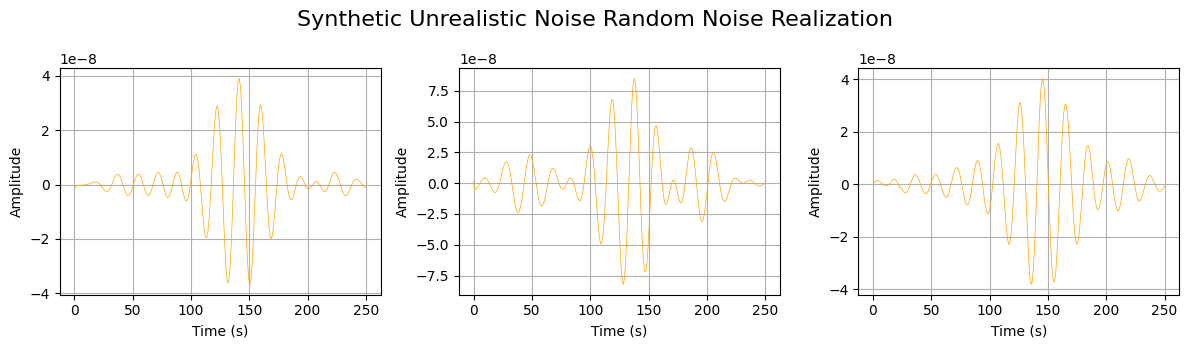

In [5]:
if(True):
    # Now plot the input noise signals with a realization from the estimated Gaussian to see if they fit

    fig_height = 3.5  # Adjust scaling as needed
    fig, axes = plt.subplots(1, 3, figsize=(12, fig_height), sharex=True)
    noise_stat,noise_realization = 0,6
    # noise = [low_amps_z,low_amps_r,low_amps_t]
    #cdn = [cd_z,cd_r,cd_t]
    # res = [res_z,res_r,res_t]
    for i in range(1):
        for j, comp in enumerate(['Z', 'R', 'T']):
            ax = axes[j]
            #ax.plot(time, ydatas[0][:, j], c='k', label=f'{stations[i]} {comp}')
            #ax.plot(time, ydatas[0][:, j]-res[j][0], c='r', label='SF Son et al. 2025')
            # ax.plot(time,res[j][0],c='k',lw=0.5)
            ax.plot(tt,np.random.multivariate_normal(np.zeros(250),Cd_set[j]),c='orange',lw=0.5)
            ax.set_ylabel(f'Amplitude')
            ax.set_xlabel('Time (s)')
            ax.grid(True)
            #ax.legend(loc='upper right', fontsize=8)
    plt.suptitle('Synthetic Unrealistic Noise Random Noise Realization', fontsize=16)
    plt.tight_layout()
    plt.show()    

In [6]:
noise_z = np.random.multivariate_normal(np.zeros(data_len), C_ddz)*0.2 # z-component correlated noise, adjusted to "realistic levels"
noise_r = np.random.multivariate_normal(np.zeros(data_len), C_ddr)*0.2 # r-component correlated noise
noise_t = np.random.multivariate_normal(np.zeros(data_len), C_ddt)*0.2 # t-component correlated noise

In [7]:
## adding a small value to the data to account for numerical stability
# This is a common practice to avoid singular matrices in numerical computations.
Cddinv_z = cdinv_real[0][0][0]
Cddinv_r = cdinv_real[0][0][1]
Cddinv_t = cdinv_real[0][0][2]

## finding the log of the determinants of the covariance matrices
# log(sqrt(det(C^-1))) = -1/2 sum(log(lambda_i)) for lambda being the eigenvalues of C

C_ddz_sum, C_ddr_sum, C_ddt_sum = 0, 0, 0
for i in range(len(np.linalg.eig(C_ddz)[0])):
    C_ddz_sum += np.log(np.linalg.eig(C_ddz)[0][i])
for i in range(len(np.linalg.eig(C_ddr)[0])):
    C_ddr_sum += np.log(np.linalg.eig(C_ddr)[0][i])
for i in range(len(np.linalg.eig(C_ddt)[0])):
    C_ddt_sum += np.log(np.linalg.eig(C_ddt)[0][i])

print("C_ddz_sum:", C_ddz_sum)
print("C_ddr_sum:", C_ddr_sum)
print("C_ddt_sum:", C_ddt_sum)

Cddinv_z_logdet = 0.5*(-C_ddz_sum).real # this is all real, but this helps it format the values properly
Cddinv_r_logdet = 0.5*(-C_ddr_sum).real
Cddinv_t_logdet = 0.5*(-C_ddt_sum).real

print("c_ddz_inv_det:", Cddinv_z_logdet)
print("c_ddr_inv_det:", Cddinv_r_logdet)
print("c_ddt_inv_det:", Cddinv_t_logdet)

C_ddz_sum: (-17453.78269203383+37.69911184307752j)
C_ddr_sum: (-17434.38066872524+40.840704496667314j)
C_ddt_sum: (-17126.710188342306+47.12388980384691j)
c_ddz_inv_det: 8726.891346016915
c_ddr_inv_det: 8717.19033436262
c_ddt_inv_det: 8563.355094171153


## Generating the Synthetic "Real" Data and Green's Functions

In [8]:
from pyproj import Geod

geod = Geod(ellps="WGS84")

distances = [] # in metres
for i in range(len(bulk_stations)):
    distances.append(distance(event_lat, event_lon, bulk_stations[i]['latitude'], bulk_stations[i]['longitude']))

begin_times = []
arrival_times = []
end_times = []

for i in range(len(bulk_stations)):
    time_to_arrive = distances[i] / 2950  # Assuming average seismic wave speed of 2950 m/s
    arrival_times.append(obspy.UTCDateTime(event_time) + time_to_arrive)
    begin_time = obspy.UTCDateTime(event_time) + time_to_arrive - 350
    end_time = obspy.UTCDateTime(event_time) + time_to_arrive + 300
    begin_times.append(begin_time)
    end_times.append(end_time)

realstarttime = min(begin_times) - 10 # buffers for the artificially-induced time offsets
realendtime = max(end_times) + 10
ttot = realendtime - realstarttime

starter_time = obspy.UTCDateTime(event_time) - realstarttime

arrival_times_expanded = [arrival_time for arrival_time in arrival_times for _ in range(3)]

coche = client.get_model_info(model_name='prem_a_10s')
time_info = [starter_time, ttot, arrival_times_expanded]

time_offsets = [0.5, 6, -3, 2, -1, 4, 0.1, -4,
                5, 0.2, -4, -0.1, 3, 1.5, 0.01, -2,
                7, 6, 1, -4, -5, 0, 2, -2] # time offsets for each station to add some variability

In [9]:
## generating the noiseless waveform
data = client.get_waveforms_bulk(
    model = 'prem_a_10s',
    bulk = bulk_stations,
    sourcelatitude = event_lat,
    sourcelongitude = event_lon,
    sourcedepthinmeters = 500,  # 500 m depth
    sourcemomenttensor = [2E14, -3E14, -2E14, 6E15, -8E15, -5E14], # moment tensor event - Mrr, Mtt, Mpp, Mrt, Mrp, Mtp
    origintime = obspy.UTCDateTime(event_time),
    starttime = -starter_time,
    endtime = ttot,
    components = 'ZRT',
    units = 'displacement'
)

# data = convolution_function(data)

data.resample(1.0)

# for tr in data:
#     if tr.stats.channel.endswith('R'): tr.data *= -1

data.detrend('demean')
data.detrend('linear')
data.taper(max_percentage=0.1)

for i in range(len(data)):
    data[i].filter('bandpass', freqmin = 0.04, freqmax = 0.06, corners = 3, zerophase = True)
    data[i].trim(starttime=arrival_times_expanded[i]-150+time_offsets[i], endtime=arrival_times_expanded[i]+100+time_offsets[i])
    
    # Ensure exactly 250 samples
    if len(data[i].data) > 250:
        # Trim to first 250 samples
        data[i].data = data[i].data[:250]
        data[i].stats.npts = 250
    elif len(data[i].data) < 250:
        # Pad with zeros to reach 250 samples
        padding = np.zeros(250 - len(data[i].data))
        data[i].data = np.concatenate([data[i].data, padding])
        data[i].stats.npts = 250

data.taper(max_percentage=0.15)

station_streems_data = []
ydatas = []

for station in stations:
    station_streem = data.select(station=station)
    station_streeme = station_streem.select(component='Z') + \
                    station_streem.select(component='R') + \
                    station_streem.select(component='T')

    data_z = station_streeme[0].data + noise_z
    data_r = station_streeme[1].data + noise_r
    data_t = station_streeme[2].data + noise_t
    
    station_streeme[0].data = data_z
    station_streeme[1].data = data_r
    station_streeme[2].data = data_t
    
    ydata = np.zeros((data_len, 3))
    ydata[:, 0] = data_z
    ydata[:, 1] = data_r
    ydata[:, 2] = data_t
    
    station_streems_data.append(station_streeme)
    ydatas.append(ydata)

    print(f"Created {len(station_streems_data)} station streams with corresponding ydata arrays")

#data[0:3].plot(type='relative', size=(400, 300), color='black', grid=True, show=False)

Created 1 station streams with corresponding ydata arrays
Created 2 station streams with corresponding ydata arrays
Created 3 station streams with corresponding ydata arrays
Created 4 station streams with corresponding ydata arrays
Created 5 station streams with corresponding ydata arrays
Created 6 station streams with corresponding ydata arrays
Created 7 station streams with corresponding ydata arrays
Created 8 station streams with corresponding ydata arrays


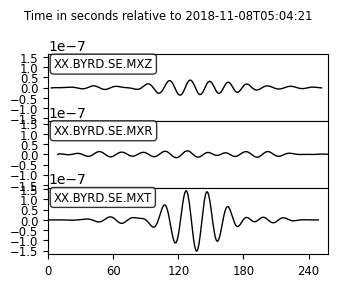

In [10]:
plotcheck = station_streems_data[0].plot(type='relative', size=(400, 300), color='black', grid=True, show=True)

In [11]:
# setting up the scaling factors for the elementary functions 
scaling_SF = np.array([1E9, 1E9, 1E8]) # Fr, Ft, Fp << matched from Son's for order of mag 
scaling_MT = np.array([1E13, 1E13, 1E13, 1E15, 1E15, 1E13]) # Mrr, Mtt, Mpp, Mrt, Mrp, Mtp << like 4 orders of magnitude larger

In [12]:
def SF_elementary_func(set):
    data = client.get_waveforms_bulk(
        model = 'prem_a_10s',
        bulk = bulk_stations,
        sourcelatitude = event_lat,
        sourcelongitude = event_lon,
        sourcedepthinmeters = 500,  # 500 m depth
        sourceforce = set*scaling_SF, # single force event - Fr, Ft, Fp
        origintime = obspy.UTCDateTime(event_time),
        starttime = -starter_time,
        endtime = ttot, 
        components = 'ZRT',
        units = 'displacement'
    )
    
    conv_data = convolution_function(data)
    
    conv_data.resample(1.0)

    for tr in conv_data:
        # correct for sign flip in the radial component
        if tr.stats.channel.endswith('R'): tr.data *= -1

    conv_data.detrend('demean')
    conv_data.detrend('linear')
    conv_data.taper(max_percentage=0.1)
    
    for i in range(len(conv_data)):
        conv_data[i].filter('bandpass', freqmin = 0.04, freqmax = 0.06, corners = 3, zerophase = True) # ok looks like this happens post conv.
        conv_data[i].trim(starttime=arrival_times_expanded[i]-150, endtime=arrival_times_expanded[i]+100)
        conv_data[i].taper(max_percentage=0.15)

        #data[i].trim(starttime=data[i].stats.starttime + 200, endtime=data[i].stats.endtime - 200)
        
        # Ensure exactly 250 samples
        if len(conv_data[i].data) > 250:
            # Trim to first 250 samples
            conv_data[i].data = conv_data[i].data[:250]
            conv_data[i].stats.npts = 250
        elif len(conv_data[i].data) < 250:
            # Pad with zeros to reach 250 samples
            padding = np.zeros(250 - len(conv_data[i].data))
            conv_data[i].data = np.concatenate([conv_data[i].data, padding])
            conv_data[i].stats.npts = 250

        # # Update endtime to match new length
        # data[i].stats.endtime = data[i].stats.starttime + (399 / data[i].stats.sampling_rate)
    
    station_streems = []
    outputs = []
    # Fix: Extract station codes from trace stats, not the traces themselves
    for station in stations:
        station_streem = conv_data.select(station=station)
        if len(station_streem) == 3:
            station_streem = station_streem.select(component='Z') + \
                        station_streem.select(component='R') + \
                        station_streem.select(component='T')
            station_streems.append(station_streem)

            ydota = [station_streem[0].data, station_streem[1].data, station_streem[2].data]            
            outputs.append(ydota)
    
    return outputs, station_streems

SF_e1, check_e1 = SF_elementary_func(np.array([1, 0, 0])) # Fr
SF_e2, check_e2 = SF_elementary_func(np.array([0, 1, 0])) # Ft
SF_e3, check_e3 = SF_elementary_func(np.array([0, 0, 1])) # Fp

check_e1

[3 Trace(s) in Stream:
XX.BYRD.SE.MXZ | 2018-11-08T05:04:23.500000Z - 2018-11-08T05:08:32.500000Z | 1.0 Hz, 250 samples
XX.BYRD.SE.MXR | 2018-11-08T05:04:23.500000Z - 2018-11-08T05:08:32.500000Z | 1.0 Hz, 250 samples
XX.BYRD.SE.MXT | 2018-11-08T05:04:23.500000Z - 2018-11-08T05:08:32.500000Z | 1.0 Hz, 250 samples,
 3 Trace(s) in Stream:
XX.DNTW.SE.MXZ | 2018-11-08T05:01:43.500000Z - 2018-11-08T05:05:52.500000Z | 1.0 Hz, 250 samples
XX.DNTW.SE.MXR | 2018-11-08T05:01:43.500000Z - 2018-11-08T05:05:52.500000Z | 1.0 Hz, 250 samples
XX.DNTW.SE.MXT | 2018-11-08T05:01:43.500000Z - 2018-11-08T05:05:52.500000Z | 1.0 Hz, 250 samples,
 3 Trace(s) in Stream:
XX.HOWD.SE.MXZ | 2018-11-08T05:04:20.500000Z - 2018-11-08T05:08:29.500000Z | 1.0 Hz, 250 samples
XX.HOWD.SE.MXR | 2018-11-08T05:04:20.500000Z - 2018-11-08T05:08:29.500000Z | 1.0 Hz, 250 samples
XX.HOWD.SE.MXT | 2018-11-08T05:04:20.500000Z - 2018-11-08T05:08:29.500000Z | 1.0 Hz, 250 samples,
 3 Trace(s) in Stream:
XX.MECK.SE.MXZ | 2018-11-08T05:0

In [13]:
def MT_elementary_func(set):
    data = client.get_waveforms_bulk(
        model = 'prem_a_10s',
        bulk = bulk_stations,
        sourcelatitude = event_lat,
        sourcelongitude = event_lon,
        sourcedepthinmeters = 500,  # 500 m depth
        sourcemomenttensor = set*scaling_MT, # single force event - Mrr, Mtt, Mpp, Mrt, Mrp, Mtp
        origintime = obspy.UTCDateTime(event_time),
        starttime = -starter_time,
        endtime = ttot, 
        components = 'ZRT',
        units = 'displacement'
    )
    data.resample(1.0)
    data.detrend('demean')
    data.detrend('linear')
    data.taper(max_percentage=0.1)
    
    for i in range(len(data)): # no convolution required for MT sources apparently
        data[i].trim(starttime=arrival_times_expanded[i]-350, endtime=arrival_times_expanded[i]+300)
        data[i].filter('bandpass', freqmin = 0.04, freqmax = 0.06, corners = 3, zerophase = True)
        data[i].trim(starttime=data[i].stats.starttime + 200, endtime=data[i].stats.endtime - 200)
        data[i].taper(max_percentage=0.15)
        
        # Ensure exactly 250 samples
        if len(data[i].data) > 250:
            # Trim to first 250 samples
            data[i].data = data[i].data[:250]
            data[i].stats.npts = 250
        elif len(data[i].data) < 250:
            # Pad with zeros to reach 250 samples
            padding = np.zeros(250 - len(data[i].data))
            data[i].data = np.concatenate([data[i].data, padding])
            data[i].stats.npts = 250

        # # Update endtime to match new length
        # data[i].stats.endtime = data[i].stats.starttime + (399 / data[i].stats.sampling_rate)
    
    station_streems = []
    outputs = []
    # Fix: Extract station codes from trace stats, not the traces themselves
    for station in stations:
        station_streem = data.select(station=station)
        if len(station_streem) == 3:
            station_streem = station_streem.select(component='Z') + \
                        station_streem.select(component='R') + \
                        station_streem.select(component='T')
            station_streems.append(station_streem)

            ydota = [station_streem[0].data, station_streem[1].data, station_streem[2].data]            
            outputs.append(ydota)

    return outputs, station_streems

MT_e1, check_e1 = MT_elementary_func(np.array([1, 0, 0, 0, 0, 0])) # Mrr
MT_e2, check_e2 = MT_elementary_func(np.array([0, 1, 0, 0, 0, 0])) # Mtt
MT_e3, check_e3 = MT_elementary_func(np.array([0, 0, 1, 0, 0, 0])) # Mpp
MT_e4, check_e4 = MT_elementary_func(np.array([0, 0, 0, 1, 0, 0])) # Mrt
MT_e5, check_e5 = MT_elementary_func(np.array([0, 0, 0, 0, 1, 0])) # Mrp
MT_e6, check_e6 = MT_elementary_func(np.array([0, 0, 0, 0, 0, 1])) # Mtp

check_e1

[3 Trace(s) in Stream:
XX.BYRD.SE.MXZ | 2018-11-08T05:04:24.000000Z - 2018-11-08T05:08:33.000000Z | 1.0 Hz, 250 samples
XX.BYRD.SE.MXR | 2018-11-08T05:04:24.000000Z - 2018-11-08T05:08:33.000000Z | 1.0 Hz, 250 samples
XX.BYRD.SE.MXT | 2018-11-08T05:04:24.000000Z - 2018-11-08T05:08:33.000000Z | 1.0 Hz, 250 samples,
 3 Trace(s) in Stream:
XX.DNTW.SE.MXZ | 2018-11-08T05:01:44.000000Z - 2018-11-08T05:05:53.000000Z | 1.0 Hz, 250 samples
XX.DNTW.SE.MXR | 2018-11-08T05:01:44.000000Z - 2018-11-08T05:05:53.000000Z | 1.0 Hz, 250 samples
XX.DNTW.SE.MXT | 2018-11-08T05:01:44.000000Z - 2018-11-08T05:05:53.000000Z | 1.0 Hz, 250 samples,
 3 Trace(s) in Stream:
XX.HOWD.SE.MXZ | 2018-11-08T05:04:20.000000Z - 2018-11-08T05:08:29.000000Z | 1.0 Hz, 250 samples
XX.HOWD.SE.MXR | 2018-11-08T05:04:20.000000Z - 2018-11-08T05:08:29.000000Z | 1.0 Hz, 250 samples
XX.HOWD.SE.MXT | 2018-11-08T05:04:20.000000Z - 2018-11-08T05:08:29.000000Z | 1.0 Hz, 250 samples,
 3 Trace(s) in Stream:
XX.MECK.SE.MXZ | 2018-11-08T05:0

In [14]:
Glist = []
for i in range(len(stations)):
    GSF = np.transpose([SF_e1[i], SF_e2[i], SF_e3[i]])
    GMT = np.transpose([MT_e1[i], MT_e2[i], MT_e3[i], MT_e4[i], MT_e5[i], MT_e6[i]])
    Glist.append([GSF, GMT]) # list of G matrices for each state

In [15]:
son_model_exact = np.array([-4.0,4.0,7.0])
res_z,res_r,res_t = calc_residuals(son_model_exact, 0, Glist, ydatas, num_stations=8) # calculate waveform residuals of Son's model
res = [res_z,res_r,res_t]

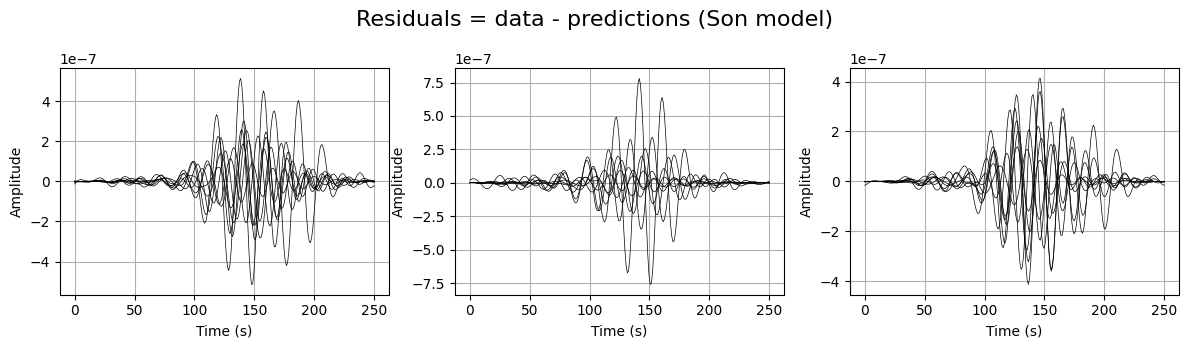

In [16]:
# Now plot the residual waveforms of Son's model

fig_height = 3.5  # Adjust scaling as needed
fig, axes = plt.subplots(1, 3, figsize=(12, fig_height), sharex=True)
noise_stat,noise_realization = 0,6
# noise = [low_amps_z,low_amps_r,low_amps_t]
#cdn = [cd_z,cd_r,cd_t]
res = [res_z,res_r,res_t]
time_x = np.linspace(0,250,250)
for i in range(len(stations)):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        #ax.plot(time_x, ydatas[0][:, j], c='k', label=f'{stations[i]} {comp}')
        #ax.plot(time_x, ydatas[0][:, j]-res[j][0], c='r', label='SF Son et al. 2025')
        ax.plot(time_x,res[j][i],c='k',lw=0.5)
        ax.set_ylabel(f'Amplitude')
        ax.set_xlabel('Time (s)')
        ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
plt.suptitle('Residuals = data - predictions (Son model)', fontsize=16)
plt.tight_layout()
plt.show()   

## Problem Setup

In [17]:
# defining the dimensional space of the thing
nstates = 2
ndims = [3, 6] # 3 for SF, 6 for MT
sigmas = [50, 50] # weaker prior model covariance << this has made the prior much stronger

# prior PDF parameters (approximate expected parameter values)
mu_SF = [-3, 2, 6] # << more or less taken fron Son's -2.747817857774633 1.7271417083824983 6.147906282830952
mu_MT = [25, -25, -20, 10, -3, -40] # << a guess 26.978422827945437 -25.430668819981314 -15.52056466383073 13.11266483895689 -2.9515670217858716 -41.58499996697125
mu = [mu_SF, mu_MT]

# covariance / data covariance matrices
cov =   [np.eye(ndims[i]) * sigmas[i]**2 for i in range(nstates)] # covariance matrices for each state
cov_dets =   [np.linalg.det(cov[i]) for i in range(nstates)]   # determinants of covariance matrices

# Cddinv_z = cdinv_real[0][0][0]
# Cddinv_r = cdinv_real[0][0][1]
# Cddinv_t = cdinv_real[0][0][2]

# Cdinv_set = [[Cddinv_z, Cddinv_r, Cddinv_t]]  # inverse data covariance matrices for each state << I am repeating the same for all the stations

# cdinv = [[Cdinv_set[0], Cdinv_set[0]], [Cdinv_set[0], Cdinv_set[0]], [Cdinv_set[0], Cdinv_set[0]], [Cdinv_set[0], Cdinv_set[0]],
#          [Cdinv_set[0], Cdinv_set[0]], [Cdinv_set[0], Cdinv_set[0]], [Cdinv_set[0], Cdinv_set[0]], [Cdinv_set[0], Cdinv_set[0]]] # this gets replaced lower down
cdinv = cdinv_real

logdet_set = [[None, None, None]]

log_cdinv_dets = [[logdet_set[0], logdet_set[0]], [logdet_set[0], logdet_set[0]], [logdet_set[0], logdet_set[0]], [logdet_set[0], logdet_set[0]],
                  [logdet_set[0], logdet_set[0]], [logdet_set[0], logdet_set[0]], [logdet_set[0], logdet_set[0]], [logdet_set[0], logdet_set[0]]]

In [18]:
# setting up the log likelihood function
def log_likelihood(x, state, y, cdinv, log_cdinv_dets, Glist, align=True, verbose=False,returnlikes=False):
    '''
    Gaussian log likelihood function - requires you to input the "G matrix" for each state you want to test
    y is the data going in
    '''
    
    ll_z_sum, ll_n_sum, ll_e_sum = 0, 0, 0
    ll_zs,ll_ns,ll_es = [],[],[]
    
    for i in range(len(stations)):
        G = Glist[i][state]
        Cdinv_z, Cdinv_n, Cdinv_e = cdinv[i][state]
        Cdinv_det_z, Cdinv_det_n, Cdinv_det_e = log_cdinv_dets[i][state]
        data_z, data_r, data_t = y[i][:,0], y[i][:,1], y[i][:,2]
        model_z, model_r, model_t = np.dot(G[:,0], x), np.dot(G[:,1], x), np.dot(G[:,2], x)
        
        if(align):
            d_obs = np.vstack((data_z, data_r, data_t))
            d_pred = np.vstack((model_z, model_r, model_t))
            residuals, tshifts = station_residual(d_obs, d_pred, max_shift=30, shifts_per_station=3, return_tshift=True)
            if(verbose):
                print(' Station ', i, ' offsets detected ', -tshifts)
            aligned = np.zeros_like(d_pred)
            for j in range(3): aligned[j] = np.roll(d_pred[j], -tshifts[j])
            model_z, model_r, model_t = aligned
        
        r_z = data_z - model_z
        r_n = data_r - model_r
        r_e = data_t - model_t
        ll_z = -.5 * r_z @ Cdinv_z @ r_z.T
        ll_n = -.5 * r_n @ Cdinv_n @ r_n.T
        ll_e = -.5 * r_e @ Cdinv_e @ r_e.T
        
        #ll_z += -0.5*len(data_z)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_z)
        #ll_n += -0.5*len(data_r)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_n)
        #ll_e += -0.5*len(data_t)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_e)
        ll_zs.append(ll_z)
        ll_ns.append(ll_n)
        ll_es.append(ll_e)
        
        ll_z_sum += ll_z
        ll_n_sum += ll_n
        ll_e_sum += ll_e

    if(returnlikes): return ll_z_sum + ll_n_sum + ll_e_sum,ll_zs,ll_ns,ll_es
    return ll_z_sum + ll_n_sum + ll_e_sum      
#

In [19]:
# print out table of fits for selected models
mu_SF_model = np.array(mu[0])
mu_MT_model = np.array(mu[1])
son_model_exact = np.array([-4.0,4.0,7.0])
print(f'Mu SF model:   {mu_SF_model[0]:.3f}, {mu_SF_model[1]:.3f}, {mu_SF_model[2]:.3f} \n  LL: {log_likelihood(mu_SF_model, 0, ydatas, cdinv, log_cdinv_dets, Glist):.3f} log-prior: {log_prior(mu_SF_model, 0, mu, cov, cov_dets):.3f}  log-p: {log_likelihood(mu_SF_model, 0, ydatas, cdinv, log_cdinv_dets, Glist)+log_prior(mu_SF_model, 0, mu, cov, cov_dets):.3f}')
print(f'--------------------------------------------------------------')
print(f'Mu MT model:   {mu_MT_model[0]:.3f}, {mu_MT_model[1]:.3f}, {mu_MT_model[2]:.3f}  {mu_MT_model[3]:.3f}, {mu_MT_model[4]:.3f}, {mu_MT_model[5]:.3f} \n  LL: {log_likelihood(mu_MT_model, 1, ydatas, cdinv, log_cdinv_dets, Glist):.3f}  log-prior: {log_prior(mu_MT_model, 1, mu, cov, cov_dets):.3f}   log-p: {log_likelihood(mu_MT_model, 1, ydatas, cdinv, log_cdinv_dets, Glist)+log_prior(mu_MT_model, 1, mu, cov, cov_dets):.3f}')
print(f'--------------------------------------------------------------')
print(f'Son model:  {son_model_exact[0]:.3f}, {son_model_exact[1]:.3f}, {son_model_exact[2]:.3f} \n  LL: {log_likelihood(son_model_exact, 0, ydatas, cdinv, log_cdinv_dets, Glist):.3f}  log-prior: {log_prior(son_model_exact, 0, mu, cov, cov_dets):.3f}   log-p: {log_likelihood(son_model_exact, 0, ydatas, cdinv, log_cdinv_dets, Glist)+log_prior(son_model_exact, 0, mu, cov, cov_dets):.3f}')
#print(f'Map model:   {map_model[0]:.3f}, {map_model[1]:.3f}, {map_model[2]:.3f}   LL: {log_likelihood(map_model):.3f}   log-prior: {log_prior(map_model, 0, mu, cov, cov_dets):.3f}   log-p: {lp_max:.3f}   index: {max_arg}')
#print(f'Bad model:   {bad_model[0]:.3f}, {bad_model[1]:.3f}, {bad_model[2]:.3f}  LL: {log_likelihood(bad_model):.3f}   log-prior: {log_prior(bad_model, 0, mu, cov, cov_dets):.3f}  log-p: {lp_min:.3f}   index: {min_arg}')

Mu SF model:   -3.000, 2.000, 6.000 
  LL: -0.110 log-prior: -14.493  log-p: -14.602
--------------------------------------------------------------
Mu MT model:   25.000, -25.000, -20.000  10.000, -3.000, -40.000 
  LL: -0.004  log-prior: -28.986   log-p: -28.990
--------------------------------------------------------------
Son model:  -4.000, 4.000, 7.000 
  LL: -0.260  log-prior: -14.494   log-p: -14.754


In [20]:
# setting up the log posterior function
def log_posterior(x, state, y, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets):
    '''
    log posterior = log likelihood + log prior
    '''
    lp = log_likelihood(x, state, y, cdinv, log_cdinv_dets, Glist) 
    lp += log_prior(x,state,mu,cov, cov_dets)
    return lp

log_posterior_args = [ydatas, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets]  

In [21]:
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = np.array(mu[i]) # arbitrary initial guesses for optimisation
    print(f' Optimising full log likelihood for state {i}...') # x, state, y, cdinv, log_cdinv_dets, Glist,
    obj_fun = lambda *args: -log_posterior(*args)
    soln = minimize(obj_fun, initial, args=(i, ydatas, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets), method='nelder-mead')
    ml.append(soln.x)
    print(soln.x)
    #print("x_ml = {0:.3f}".format(soln.x[0]))
    print(f'NLL of starting model {i} prior to minimisation: {obj_fun(initial, i, ydatas, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets):.3f}')
    print(f'NLL of ML model {i} after minimisation: {obj_fun(soln.x, i, ydatas, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets):.3f}')


Maximum likelihood estimates:
 Optimising full log likelihood for state 0...
[-0.84610069 -0.03407957  8.64349503]
NLL of starting model 0 prior to minimisation: 14.602
NLL of ML model 0 after minimisation: 14.505
 Optimising full log likelihood for state 1...
[ 24.88871399 -24.78362497 -19.90409612   9.40346709  -3.4461347
 -39.97906182]
NLL of starting model 1 prior to minimisation: 28.990
NLL of ML model 1 after minimisation: 28.990


## Setting up the Sampler

In [22]:
# setup of MCMC sampler
nsamples =[30000, 30000] # number of samples per chain for sampling of each state
nwalkers = [32,32] # number of mcmc chains to run simultaneously in each state
pos = []
for i in range(nstates): # generate starting points for each chain in each state
    pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers[i], ndims[i])) # add random perturbation to maximum Likelihood models

In [23]:
# perform initiation of sampler
tcs3 = TransC_Sampler(nstates,ndims) # create instances of states

In [24]:
# first step: run Ensemble sampler in each state
start_time = time.time()
ensemble_per_state, log_posterior_ens = tcs3.run_mcmc_per_state( 
        nwalkers,                                  # int or list containing number of walkers for each state
        nsamples,                                  # number of chain steps per walker
        pos,                                       # starting positions for walkers in each state
        log_posterior,                             # log Likelihood x log_prior
        log_posterior_args=log_posterior_args,     # log posterior additional arguments (optional)
        discard=0,                                 # burnin number of chain steps to discard in eeach state
        autothin=True,                             # thinning value, save every `thin` models
        progress=True)                             # show progress bar for each state
elapsed_time = time.time() - start_time
print(' Elapsed time                                     :', np.round(elapsed_time,2),'s \n')
print(' Number of samples in each state                  :',*[len(tcs3.ensemble_per_state[i]) for i in range(nstates)])


Running within-state sampler separately on each state

Number of walkers               :  [32, 32]

Number of states being sampled:  2
Dimensions of each state:  [3, 6]


100%|██████████| 30000/30000 [3:35:33<00:00,  2.32it/s]  


 Elapsed time                                     : 20060.12 s 

 Number of samples in each state                  : 47996 28231


In [25]:
log_prior_ens = []
for i in range(nstates):
    ens = ensemble_per_state[i]
    log_prior_ens.append([log_prior(ens[k], i, mu, cov, cov_dets) for k in range(len(ens))])
log_pseudo_prior_ens = log_prior_ens # NB we set the log-pseudo-prior values to the log-prior values

In [26]:
# Calculate marginal Likelihoods using ensembles for each state
nwalkers = 64   # number of independent random walkers across ensembles
nsteps = 400000 # number of chain steps for each walker
start_time = time.time()
result = tcs3.run_ensemble_resampler(nwalkers,
                                   nsteps,
                                   progress=True,
                                   parallel=parallel,
                                   log_posterior_ens=log_posterior_ens,
                                   log_pseudo_prior_ens=log_pseudo_prior_ens) # run mcmc sampler over ensembles to get marginal Likelihoods between states
elapsed_time = time.time() - start_time


Running ensemble trans-D resampler

Number of walkers               :  64
Number of states being sampled  :  2
Dimensions of each state        :  [3, 6]


100%|██████████| 64/64 [35:37<00:00, 33.39s/it]


In [27]:
chain, states_chain = print_diagnostics(tcs3, elapsed_time)


 Algorithm type                                      : TransC-ensemble-resampler
 Average % acceptance rate for within states         : 100.0
 Average % acceptance rate for between states        : 71.39
 Auto correlation time for between state sampling    : -0.02
 Total number of state changes for all walkers       : 805573
 Estimated relative evidences                        : 0.38322 0.61678
 Elapsed time                                        : 2137.18 s 



 State;  0  in  3  dimensions
 State;  1  in  6  dimensions


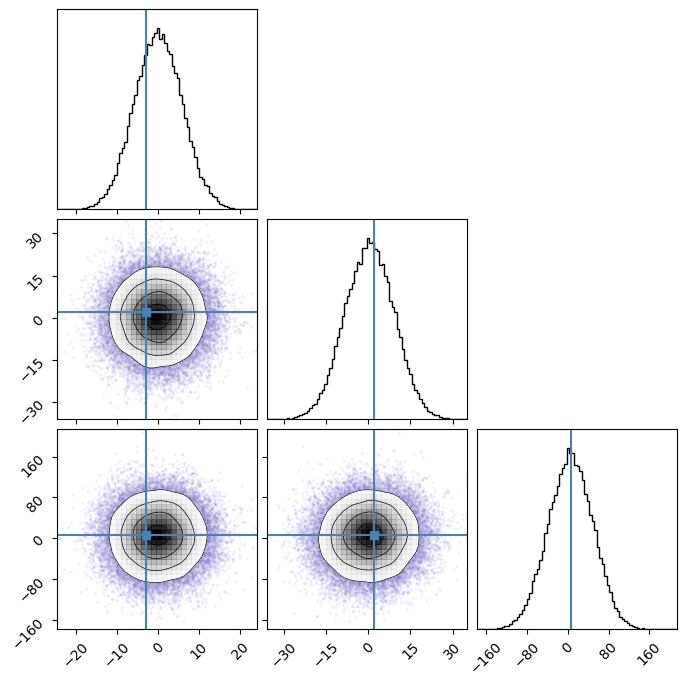

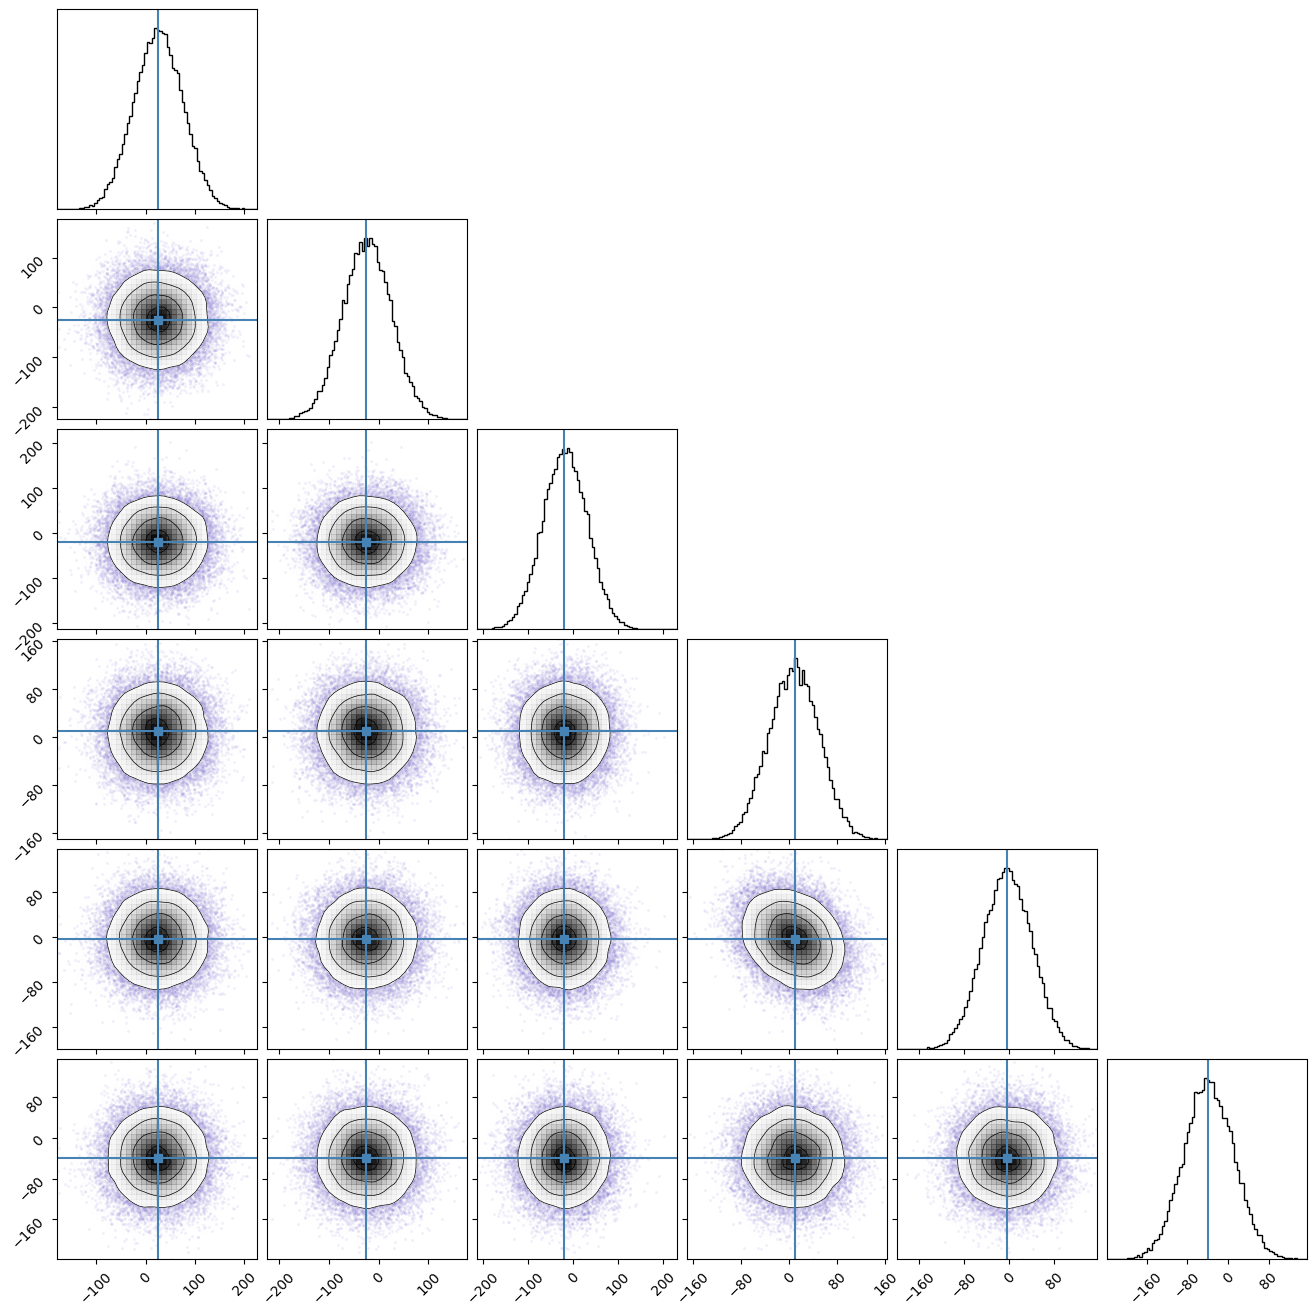

In [28]:
corner_plot = corner_plots(ensemble_per_state, mu, nstates, ndims)

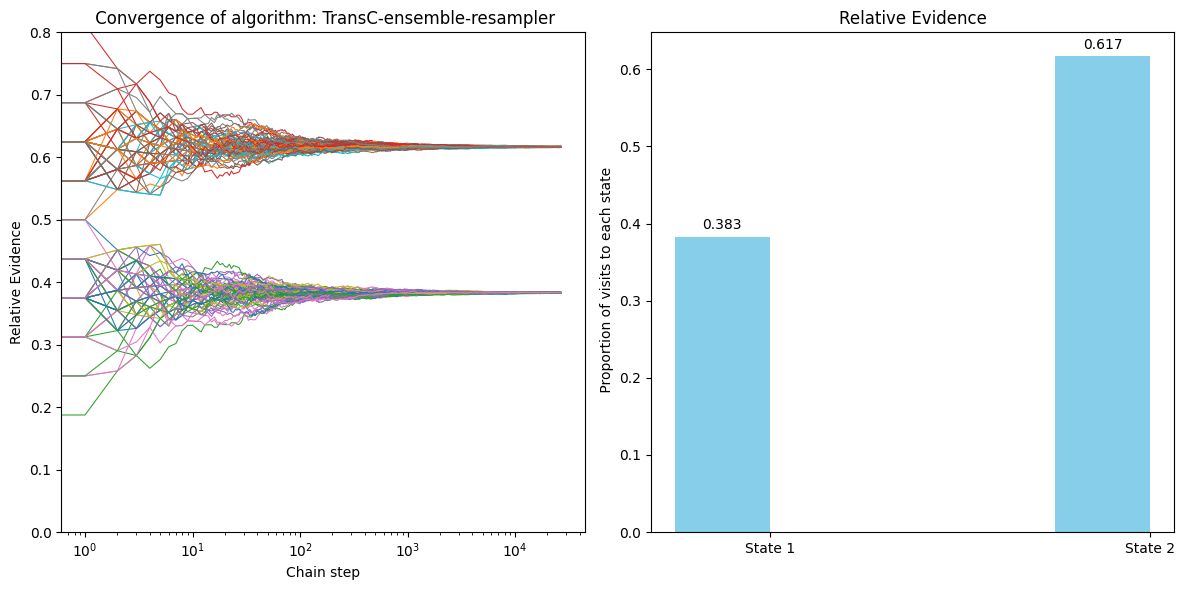

In [29]:
ratio_plot = plot_ratios(tcs3, chain, states_chain, nstates, nsamples = 400000)

In [30]:
# SFs = [SF_e1, SF_e2, SF_e3]
# MTs = [MT_e1, MT_e2, MT_e3, MT_e4, MT_e5, MT_e6]
# other_infos = [mu, cov, cov_dets, ydatas, cdinv, log_cdinv_dets, Glist, stations]

# SF_force_opt_MAP, MT_force_opt_MAP, SF_force_az_MAP, SF_opt_signals_MAP, MT_opt_signals_MAP = MAP_stuff(tcs3, scaling_SF, scaling_MT, SFs, MTs, other_infos)

max_arg_SF = np.argmax(tcs3.log_posterior_ens[0])
print(max_arg_SF)
max_arg_MT = np.argmax(tcs3.log_posterior_ens[1])
print(max_arg_MT)
min_arg_SF = np.argmin(tcs3.log_posterior_ens[0])
print(min_arg_SF)
min_arg_MT = np.argmin(tcs3.log_posterior_ens[1])
print(min_arg_MT)

print('--------------------------------------------')

print(f'log posterior SF max: {tcs3.log_posterior_ens[0][max_arg_SF]}')
print(f'log prior + log likelihood SF max: {log_prior(tcs3.ensemble_per_state[0][max_arg_SF], 0, mu, cov, cov_dets)} + {log_likelihood(tcs3.ensemble_per_state[0][max_arg_SF], 0, ydatas, cdinv, log_cdinv_dets, Glist)}')
print(f'log posterior MT max: {tcs3.log_posterior_ens[1][max_arg_MT]}')
print(f'log prior + log likelihood MT max: {log_prior(tcs3.ensemble_per_state[1][max_arg_MT], 1, mu, cov, cov_dets)} + {log_likelihood(tcs3.ensemble_per_state[1][max_arg_MT], 1, ydatas, cdinv, log_cdinv_dets, Glist)}')
print(f'log posterior SF min: {tcs3.log_posterior_ens[0][min_arg_SF]}')
print(f'log prior + log likelihood SF min: {log_prior(tcs3.ensemble_per_state[0][min_arg_SF], 0, mu, cov, cov_dets)} + {log_likelihood(tcs3.ensemble_per_state[0][min_arg_SF], 0, ydatas, cdinv, log_cdinv_dets, Glist)}')
print(f'log posterior MT min: {tcs3.log_posterior_ens[1][min_arg_MT]}')
print(f'log prior + log likelihood MT min: {log_prior(tcs3.ensemble_per_state[1][min_arg_MT], 1, mu, cov, cov_dets)} + {log_likelihood(tcs3.ensemble_per_state[1][min_arg_MT], 1, ydatas, cdinv, log_cdinv_dets, Glist)}')

print('--------------------------------------------')

print('Most likely: ')
print(tcs3.ensemble_per_state[0][max_arg_SF]) # SF MAP
print(tcs3.ensemble_per_state[1][max_arg_MT]) # MT MAP
print('Least likely: ')
print(tcs3.ensemble_per_state[0][min_arg_SF]) # SF least likely
print(tcs3.ensemble_per_state[1][min_arg_MT]) # MT least likely

# finding the selected optimised values (map)

SF_opt_1_map, SF_opt_2_map, SF_opt_3_map = tcs3.ensemble_per_state[0][max_arg_SF]
MT_opt_1_map, MT_opt_2_map, MT_opt_3_map, MT_opt_4_map, MT_opt_5_map, MT_opt_6_map = tcs3.ensemble_per_state[1][max_arg_MT]

SF_force_opt_MAP = ([SF_opt_1_map, SF_opt_2_map, SF_opt_3_map])*scaling_SF
MT_force_opt_MAP = ([MT_opt_1_map, MT_opt_2_map, MT_opt_3_map, MT_opt_4_map, MT_opt_5_map, MT_opt_6_map])*scaling_MT

print('--------------------------------------------')

print('SF force optimised (N): ', SF_force_opt_MAP)
print('MT force optimised (N): ', MT_force_opt_MAP)

SF_force_az_MAP = 180 - np.arctan(SF_force_opt_MAP[2] / SF_force_opt_MAP[1])
print(SF_force_az_MAP)

sliprate = stf_tsai2007(source_duration=15, deltat=coche.dt)
CSFamp = np.max(np.cumsum(np.cumsum(sliprate)) * coche.dt**2 * np.sqrt(np.sum(SF_force_opt_MAP**2)))
txt = f"CSF amp: {CSFamp/1e11:.1f}" + "$10^{11}$ kg-m"
print(txt)  

SF_opt_signals_MAP = []
MT_opt_signals_MAP = []

for i in range(len(stations)):
    SF_optimised_z = SF_opt_1_map*SF_e1[i][0] + SF_opt_2_map*SF_e2[i][0] + SF_opt_3_map*SF_e3[i][0]
    SF_optimised_r = SF_opt_1_map*SF_e1[i][1] + SF_opt_2_map*SF_e2[i][1] + SF_opt_3_map*SF_e3[i][1]
    SF_optimised_t = SF_opt_1_map*SF_e1[i][2] + SF_opt_2_map*SF_e2[i][2] + SF_opt_3_map*SF_e3[i][2]

    SF_opt_signals_MAP.append([SF_optimised_z, SF_optimised_r, SF_optimised_t])

    MT_optimised_z = MT_opt_1_map*MT_e1[i][0] + MT_opt_2_map*MT_e2[i][0] + MT_opt_3_map*MT_e3[i][0] + MT_opt_4_map*MT_e4[i][0] + MT_opt_5_map*MT_e5[i][0] + MT_opt_6_map*MT_e6[i][0]
    MT_optimised_r = MT_opt_1_map*MT_e1[i][1] + MT_opt_2_map*MT_e2[i][1] + MT_opt_3_map*MT_e3[i][1] + MT_opt_4_map*MT_e4[i][1] + MT_opt_5_map*MT_e5[i][1] + MT_opt_6_map*MT_e6[i][1]
    MT_optimised_t = MT_opt_1_map*MT_e1[i][2] + MT_opt_2_map*MT_e2[i][2] + MT_opt_3_map*MT_e3[i][2] + MT_opt_4_map*MT_e4[i][2] + MT_opt_5_map*MT_e5[i][2] + MT_opt_6_map*MT_e6[i][2]

    MT_opt_signals_MAP.append([MT_optimised_z, MT_optimised_r, MT_optimised_t])

6
2
24508
12908
--------------------------------------------
log posterior SF max: -14.505157961903832
log prior + log likelihood SF max: -14.496037611094485 + -0.009120350809347089
log posterior MT max: -28.98953875481558
log prior + log likelihood MT max: -28.985893660848674 + -0.0036450939669055707
log posterior SF min: -27.107657482089277
log prior + log likelihood SF min: -20.670497455139195 + -6.437160026950083
log posterior MT min: -44.4937157528503
log prior + log likelihood MT min: -43.74137299594153 + -0.7523427569087657
--------------------------------------------
Most likely: 
[-0.8461352  -0.03391848  8.64367509]
[ 24.88990698 -24.78471911 -19.90414318   9.40413095  -3.44607667
 -39.97887955]
Least likely: 
[ -5.19664461 -23.48866488 179.87802308]
[ 125.62298537  -98.8301447   -82.99809375 -111.84148272  155.94614671
   78.84510544]
--------------------------------------------
SF force optimised (N):  [-8.46135196e+08 -3.39184821e+07  8.64367509e+08]
MT force optimised (N)

In [31]:
SF_1_son, SF_2_son, SF_3_son, SF_4_son, SF_5_son, SF_6_son = [20, -30, -20, 6, -8, -50] # scaling_MT = np.array([1E13, 1E13, 1E13, 1E15, 1E15, 1E13]) # Mrr, Mtt, Mpp, Mrt, Mrp, Mtp << like 4 orders of magnitude larger
SF_force_opt_son = ([SF_1_son, SF_2_son, SF_3_son, SF_4_son, SF_5_son, SF_6_son])*scaling_MT
SF_optimised_signals_son = []
for i in range(len(stations)):
    SF_optimised_z = SF_1_son*MT_e1[i][0] + SF_2_son*MT_e2[i][0] + SF_3_son*MT_e3[i][0] + SF_4_son*MT_e4[i][0] + SF_5_son*MT_e5[i][0] + SF_6_son*MT_e6[i][0]
    SF_optimised_r = SF_1_son*MT_e1[i][1] + SF_2_son*MT_e2[i][1] + SF_3_son*MT_e3[i][1] + SF_4_son*MT_e4[i][1] + SF_5_son*MT_e5[i][1] + SF_6_son*MT_e6[i][1]
    SF_optimised_t = SF_1_son*MT_e1[i][2] + SF_2_son*MT_e2[i][2] + SF_3_son*MT_e3[i][2] + SF_4_son*MT_e4[i][2] + SF_5_son*MT_e5[i][2] + SF_6_son*MT_e6[i][2]

    SF_optimised_signals_son.append([SF_optimised_z, SF_optimised_r, SF_optimised_t])

In [32]:

log_likelihood(np.array([SF_1_son, SF_2_son, SF_3_son, SF_4_son, SF_5_son, SF_6_son]), 1, ydatas, cdinv, log_cdinv_dets, Glist) + log_prior(np.array([SF_1_son, SF_2_son, SF_3_son, SF_4_son, SF_5_son, SF_6_son]), 1, mu, cov, cov_dets)

np.float64(-29.027471096486405)

In [33]:
test_checker_x = np.linspace(-150, 100, 250)


In [34]:
print('Residual Statistics Grid-search SF model: ')
print('=' * 50)

rmss_z, rmss_r, rmss_t = [], [], []

model_son = []
residualss_son = []

for i in range(len(stations)):
    data_z, data_r, data_t = ydatas[i][:,0], ydatas[i][:,1], ydatas[i][:,2]
    model_z_son, model_r_son, model_t_son = SF_optimised_signals_son[i]
    d_obs = np.vstack((data_z, data_r, data_t))
    d_model = np.vstack((model_z_son, model_r_son, model_t_son))
    residuals_son, tshifts_son = station_residual(d_obs, d_model, max_shift=50, shifts_per_station=3, return_tshift=True)
    print(' Station ', i, ' Son et al. 2025 offsets detected ', tshifts_son)
    aligned_son = np.zeros_like(d_model)
    for j in range(3): aligned_son[j] = np.roll(d_model[j], -tshifts_son[j])
    model_z_son, model_r_son, model_t_son = aligned_son
    
    model_son.append([model_z_son, model_r_son, model_t_son])
    
    res_son_z = data_z - model_z_son
    res_son_r = data_r - model_r_son
    res_son_t = data_t - model_t_son
    
    residualss_son.append([res_son_z, res_son_r, res_son_t])

    rms_son_z = np.sqrt(np.mean(res_son_z**2))
    rms_son_r = np.sqrt(np.mean(res_son_r**2))
    rms_son_t = np.sqrt(np.mean(res_son_t**2))
    rmss_z.append(rms_son_z)
    rmss_r.append(rms_son_r)
    rmss_t.append(rms_son_t)

    print(f'  Station {stations[i]} Son et al. 2025 RMS Z: {rms_son_z:.3e}, R: {rms_son_r:.3e}, T: {rms_son_t:.3e}')

print('=' * 50)
print(f'Overall Son et al. 2025 RMS Z: {np.mean(rmss_z):.3e}, R: {np.mean(rmss_r):.3e}, T: {np.mean(rmss_t):.3e}')
print(f'overall RMS (all components): {(np.abs(np.mean(rmss_z)) + np.abs(np.mean(rmss_r)) + np.abs(np.mean(rmss_t)))/3:.3e}')
print('--------------------------------------------')

print('Residual Statistics SF MAP model: ')
print('=' * 50)

rmss_z, rmss_r, rmss_t = [], [], []

model_sf = []
residualss_sf = []

for i in range(len(stations)):
    data_z, data_r, data_t = ydatas[i][:,0], ydatas[i][:,1], ydatas[i][:,2]
    model_z_sf, model_r_sf, model_t_sf = SF_opt_signals_MAP[i]
    d_obs = np.vstack((data_z, data_r, data_t))
    d_model = np.vstack((model_z_sf, model_r_sf, model_t_sf))
    residuals_sf, tshifts_sf = station_residual(d_obs, d_model, max_shift=50, shifts_per_station=3, return_tshift=True)
    print(' Station ', i, ' SF MAP offsets detected ', tshifts_sf)
    aligned_sf = np.zeros_like(d_model)
    for j in range(3): aligned_sf[j] = np.roll(d_model[j], -tshifts_sf[j])
    model_z_sf, model_r_sf, model_t_sf = aligned_sf

    model_sf.append([model_z_sf, model_r_sf, model_t_sf])

    res_sf_z = data_z - model_z_sf
    res_sf_r = data_r - model_r_sf
    res_sf_t = data_t - model_t_sf

    residualss_sf.append([res_sf_z, res_sf_r, res_sf_t])

    rms_sf_z = np.sqrt(np.mean(res_sf_z**2))
    rms_sf_r = np.sqrt(np.mean(res_sf_r**2))
    rms_sf_t = np.sqrt(np.mean(res_sf_t**2))
    rmss_z.append(rms_sf_z)
    rmss_r.append(rms_sf_r)
    rmss_t.append(rms_sf_t)

    print(f'  Station {stations[i]} SF MAP RMS Z: {rms_sf_z:.3e}, R: {rms_sf_r:.3e}, T: {rms_sf_t:.3e}')
    

print('=' * 50)
print(f'Overall SF MAP RMS Z: {np.mean(rmss_z):.3e}, R: {np.mean(rmss_r):.3e}, T: {np.mean(rmss_t):.3e}')
print(f'overall RMS (all components): {(np.abs(np.mean(rmss_z)) + np.abs(np.mean(rmss_r)) + np.abs(np.mean(rmss_t)))/3:.3e}')
print('--------------------------------------------')

print('Residual Statistics MT MAP model: ')
print('=' * 50)

rmss_z, rmss_r, rmss_t = [], [], []

model_mt = []
residualss_mt = []

for i in range(len(stations)):
    data_z, data_r, data_t = ydatas[i][:,0], ydatas[i][:,1], ydatas[i][:,2]
    model_z_mt, model_r_mt, model_t_mt = MT_opt_signals_MAP[i]
    d_obs = np.vstack((data_z, data_r, data_t))
    d_model = np.vstack((model_z_mt, model_r_mt, model_t_mt))
    residuals_mt, tshifts_mt = station_residual(d_obs, d_model, max_shift=50, shifts_per_station=3, return_tshift=True)
    print(' Station ', i, ' MT MAP offsets detected ', tshifts_mt)
    aligned_MT = np.zeros_like(d_model)
    for j in range(3): aligned_MT[j] = np.roll(d_model[j], -tshifts_mt[j])
    model_z_mt, model_r_mt, model_t_mt = aligned_MT

    model_mt.append([model_z_mt, model_r_mt, model_t_mt])

    res_mt_z = data_z - model_z_mt
    res_mt_r = data_r - model_r_mt
    res_mt_t = data_t - model_t_mt

    residualss_mt.append([res_mt_z, res_mt_r, res_mt_t])

    rms_mt_z = np.sqrt(np.mean(res_mt_z**2))
    rms_mt_r = np.sqrt(np.mean(res_mt_r**2))
    rms_mt_t = np.sqrt(np.mean(res_mt_t**2))
    rmss_z.append(rms_mt_z)
    rmss_r.append(rms_mt_r)
    rmss_t.append(rms_mt_t)

    print(f'  Station {stations[i]} MT MAP RMS Z: {rms_mt_z:.3e}, R: {rms_mt_r:.3e}, T: {rms_mt_t:.3e}')

print('=' * 50)
print(f'Overall MT MAP RMS Z: {np.mean(rmss_z):.3e}, R: {np.mean(rmss_r):.3e}, T: {np.mean(rmss_t):.3e}')
print(f'overall RMS (all components): {(np.abs(np.mean(rmss_z)) + np.abs(np.mean(rmss_r)) + np.abs(np.mean(rmss_t)))/3:.3e}')

Residual Statistics Grid-search SF model: 
 Station  0  Son et al. 2025 offsets detected  [np.int64(2), np.int64(25), np.int64(-3)]
  Station BYRD Son et al. 2025 RMS Z: 1.030e-08, R: 1.190e-08, T: 1.103e-09
 Station  1  Son et al. 2025 offsets detected  [np.int64(2), np.int64(-1), np.int64(4)]
  Station DNTW Son et al. 2025 RMS Z: 1.512e-08, R: 1.215e-08, T: 1.254e-09
 Station  2  Son et al. 2025 offsets detected  [np.int64(1), np.int64(-5), np.int64(5)]
  Station HOWD Son et al. 2025 RMS Z: 9.996e-09, R: 9.058e-09, T: 1.122e-09
 Station  3  Son et al. 2025 offsets detected  [np.int64(-2), np.int64(-2), np.int64(0)]
  Station MECK Son et al. 2025 RMS Z: 1.110e-08, R: 6.181e-09, T: 1.108e-09
 Station  4  Son et al. 2025 offsets detected  [np.int64(24), np.int64(1), np.int64(0)]
  Station STEW Son et al. 2025 RMS Z: 9.962e-09, R: 1.106e-08, T: 1.107e-09
 Station  5  Son et al. 2025 offsets detected  [np.int64(-4), np.int64(5), np.int64(6)]
  Station UNGL Son et al. 2025 RMS Z: 8.748e-09

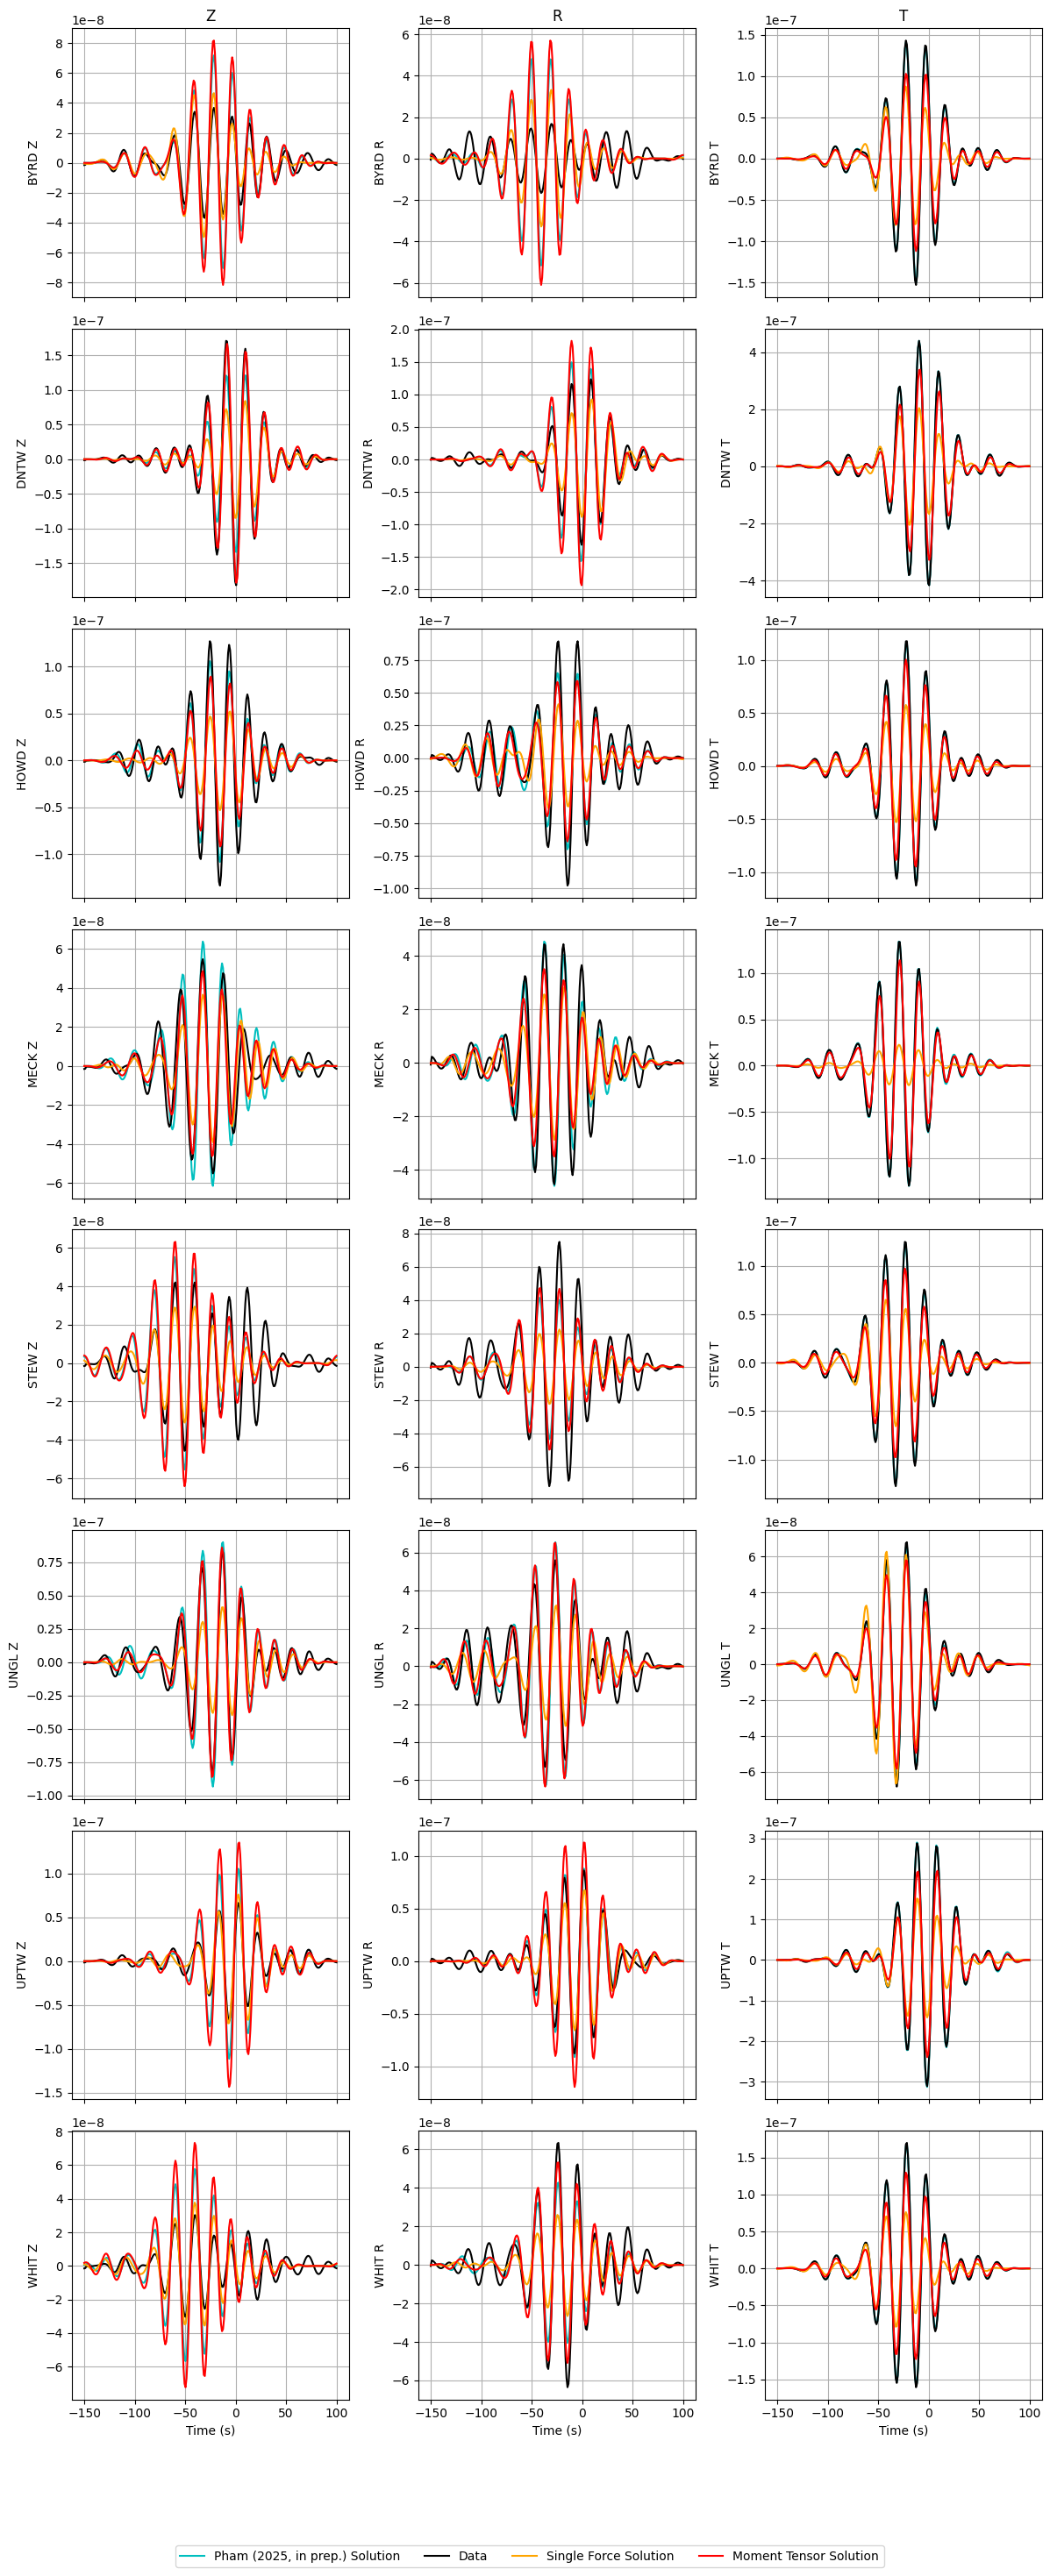

In [35]:
test_checker_x = np.linspace(-150, 100, 250)

n_stations = len(stations)
fig_height = 3.5 * n_stations  # Adjust scaling as needed
fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True)

for i in range(n_stations):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[i, j]
        ax.plot(test_checker_x, model_son[i][j], c='c', label='Pham (2025, in prep.) Solution')
        ax.plot(test_checker_x, ydatas[i][:, j], c='k', label='Data')
        ax.plot(test_checker_x, model_sf[i][j], c='orange', label='Single Force Solution')
        # ax.plot(test_checker_x, SF_optimised_signals_v1[i][j], c='r', label='SF Optimised V1')
        ax.plot(test_checker_x, model_mt[i][j], c='r', label='Moment Tensor Solution')
        # ax.plot(test_checker_x, residualss_sf[i][j], c='orange', ls='--', label='SF Residuals')
        # ax.plot(test_checker_x, residualss_mt[i][j], c='r', ls='--', label='MT Residuals')
        # ax.plot(test_checker_x, residualss_son[i][j], c='c', ls='--', label='Son et al. 2025 Residuals')
        # ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][0][0] if comp == 'Z' else cdset[0][0][1] if comp == 'R' else cdset[0][0][2]), c='lightgrey', label='ML Data Covariance')
        # ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][1][0] if comp == 'Z' else cdset[0][1][1] if comp == 'R' else cdset[0][1][2]), c='darkgrey', label='ML Data Covariance')

        ax.set_ylabel(f'{stations[i]} {comp}')
        if i == n_stations - 1:
            ax.set_xlabel('Time (s)')
        if i == 0:
            ax.set_title(comp)
        ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
        
# Get handles and labels from one of the axes (they should all be the same)
handles, labels = axes[0, 0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# plt.suptitle('Trans-Conceptual Source Inversion (Thwaites 2018-11-08)', fontsize=16)
plt.tight_layout()

plt.show()

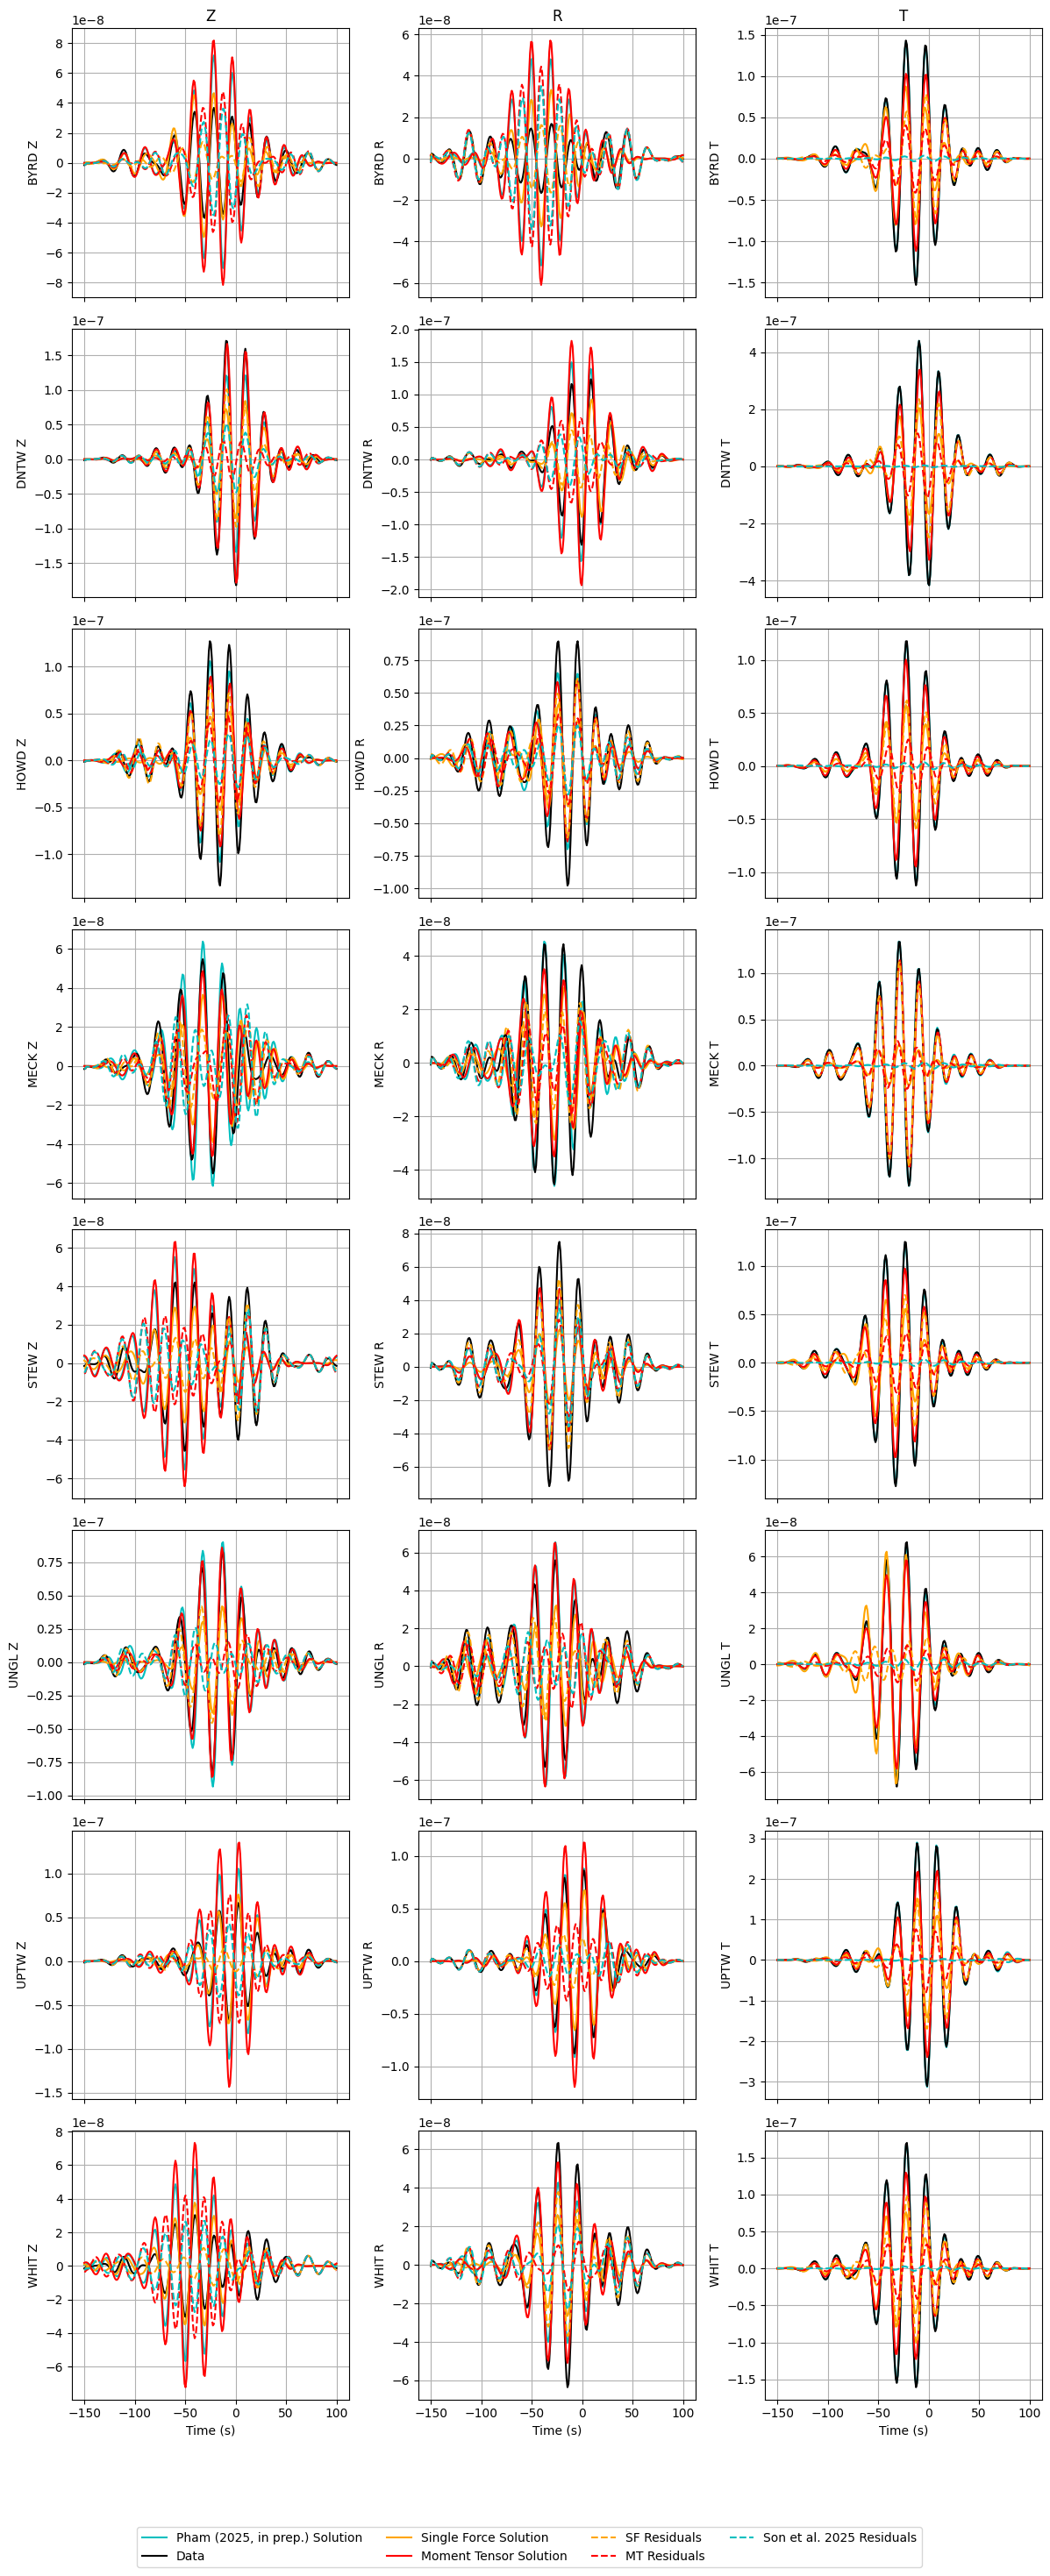

In [36]:
test_checker_x = np.linspace(-150, 100, 250)

n_stations = len(stations)
fig_height = 3.5 * n_stations  # Adjust scaling as needed
fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True)

for i in range(n_stations):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[i, j]
        ax.plot(test_checker_x, model_son[i][j], c='c', label='Pham (2025, in prep.) Solution')
        ax.plot(test_checker_x, ydatas[i][:, j], c='k', label='Data')
        ax.plot(test_checker_x, model_sf[i][j], c='orange', label='Single Force Solution')
        # ax.plot(test_checker_x, SF_optimised_signals_v1[i][j], c='r', label='SF Optimised V1')
        ax.plot(test_checker_x, model_mt[i][j], c='r', label='Moment Tensor Solution')
        ax.plot(test_checker_x, residualss_sf[i][j], c='orange', ls='--', label='SF Residuals')
        ax.plot(test_checker_x, residualss_mt[i][j], c='r', ls='--', label='MT Residuals')
        ax.plot(test_checker_x, residualss_son[i][j], c='c', ls='--', label='Son et al. 2025 Residuals')
        # ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][0][0] if comp == 'Z' else cdset[0][0][1] if comp == 'R' else cdset[0][0][2]), c='lightgrey', label='ML Data Covariance')
        # ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][1][0] if comp == 'Z' else cdset[0][1][1] if comp == 'R' else cdset[0][1][2]), c='darkgrey', label='ML Data Covariance')

        ax.set_ylabel(f'{stations[i]} {comp}')
        if i == n_stations - 1:
            ax.set_xlabel('Time (s)')
        if i == 0:
            ax.set_title(comp)
        ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
        
# Get handles and labels from one of the axes (they should all be the same)
handles, labels = axes[0, 0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# plt.suptitle('Trans-Conceptual Source Inversion (Thwaites 2018-11-08)', fontsize=16)
plt.tight_layout()

plt.show()

In [37]:
# test_checker_x = np.linspace(-150, 100, 250)

# n_stations = len(stations)
# fig_height = 3.5 * n_stations  # Adjust scaling as needed
# fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True)

# for i in range(n_stations):
#     for j, comp in enumerate(['Z', 'R', 'T']):
#         ax = axes[i, j]
#         ax.plot(test_checker_x, model_son[i][j], c='c', label='Pham (2025, in prep.) Solution')
#         ax.plot(test_checker_x, ydatas[i][:, j], c='k', label='Data')
#         ax.plot(test_checker_x, model_sf[i][j], c='orange', label='Single Force Solution')
#         # ax.plot(test_checker_x, SF_optimised_signals_v1[i][j], c='r', label='SF Optimised V1')
#         ax.plot(test_checker_x, model_mt[i][j], c='r', label='Moment Tensor Solution')
#         ax.plot(test_checker_x, residualss_sf[i][j], c='orange', ls='--', label='SF Residuals')
#         ax.plot(test_checker_x, residualss_mt[i][j], c='r', ls='--', label='MT Residuals')
#         ax.plot(test_checker_x, residualss_son[i][j], c='c', ls='--', label='Son et al. 2025 Residuals')
#         ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdinv[i][0][0] if comp == 'Z' else cdinv[i][0][1] if comp == 'R' else cdinv[i][0][2]), c='lightgrey', label='ML Data Covariance')
#         ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdinv[i][1][0] if comp == 'Z' else cdinv[i][1][1] if comp == 'R' else cdinv[i][1][2]), c='darkgrey', label='ML Data Covariance')

#         ax.set_ylabel(f'{stations[i]} {comp}')
#         if i == n_stations - 1:
#             ax.set_xlabel('Time (s)')
#         if i == 0:
#             ax.set_title(comp)
#         ax.grid(True)
#         #ax.legend(loc='upper right', fontsize=8)
        
# # Get handles and labels from one of the axes (they should all be the same)
# handles, labels = axes[0, 0].get_legend_handles_labels()

# # Add legend underneath the figure with 3 columns
# fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# # plt.suptitle('Trans-Conceptual Source Inversion (Thwaites 2018-11-08)', fontsize=16)
# plt.tight_layout()

# plt.show()

In [38]:
# test_checker_x = np.linspace(-150, 100, 250)

# n_stations = len(stations)
# fig_height = 3.5 * n_stations  # Adjust scaling as needed
# fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True)

# for i in range(n_stations):
#     for j, comp in enumerate(['Z', 'R', 'T']):
#         ax = axes[i, j]
#         # ax.plot(test_checker_x, model_son[i][j], c='c', label='Pham (2025, in prep.) Solution')
#         ax.plot(test_checker_x, ydatas[i][:, j], c='k', label='Data')
#         # ax.plot(test_checker_x, model_sf[i][j], c='orange', label='Single Force Solution')
#         # # ax.plot(test_checker_x, SF_optimised_signals_v1[i][j], c='r', label='SF Optimised V1')
#         # ax.plot(test_checker_x, model_mt[i][j], c='r', label='Moment Tensor Solution')
#         ax.plot(test_checker_x, residualss_sf[i][j], c='orange', ls='--', label='SF Residuals')
#         ax.plot(test_checker_x, residualss_mt[i][j], c='r', ls='--', label='MT Residuals')
#         ax.plot(test_checker_x, residualss_son[i][j], c='c', ls='--', label='Son et al. 2025 Residuals')
#         ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdinv[i][0][0] if comp == 'Z' else cdinv[i][0][1] if comp == 'R' else cdinv[i][0][2]), c='lightgrey', label='ML Data Covariance')
#         ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdinv[i][1][0] if comp == 'Z' else cdinv[i][1][1] if comp == 'R' else cdinv[i][1][2]), c='darkgrey', label='ML Data Covariance')

#         ax.set_ylabel(f'{stations[i]} {comp}')
#         if i == n_stations - 1:
#             ax.set_xlabel('Time (s)')
#         if i == 0:
#             ax.set_title(comp)
#         ax.grid(True)
#         #ax.legend(loc='upper right', fontsize=8)
        
# # Get handles and labels from one of the axes (they should all be the same)
# handles, labels = axes[0, 0].get_legend_handles_labels()

# # Add legend underneath the figure with 3 columns
# fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# # plt.suptitle('Trans-Conceptual Source Inversion (Thwaites 2018-11-08)', fontsize=16)
# plt.tight_layout()

# plt.show()

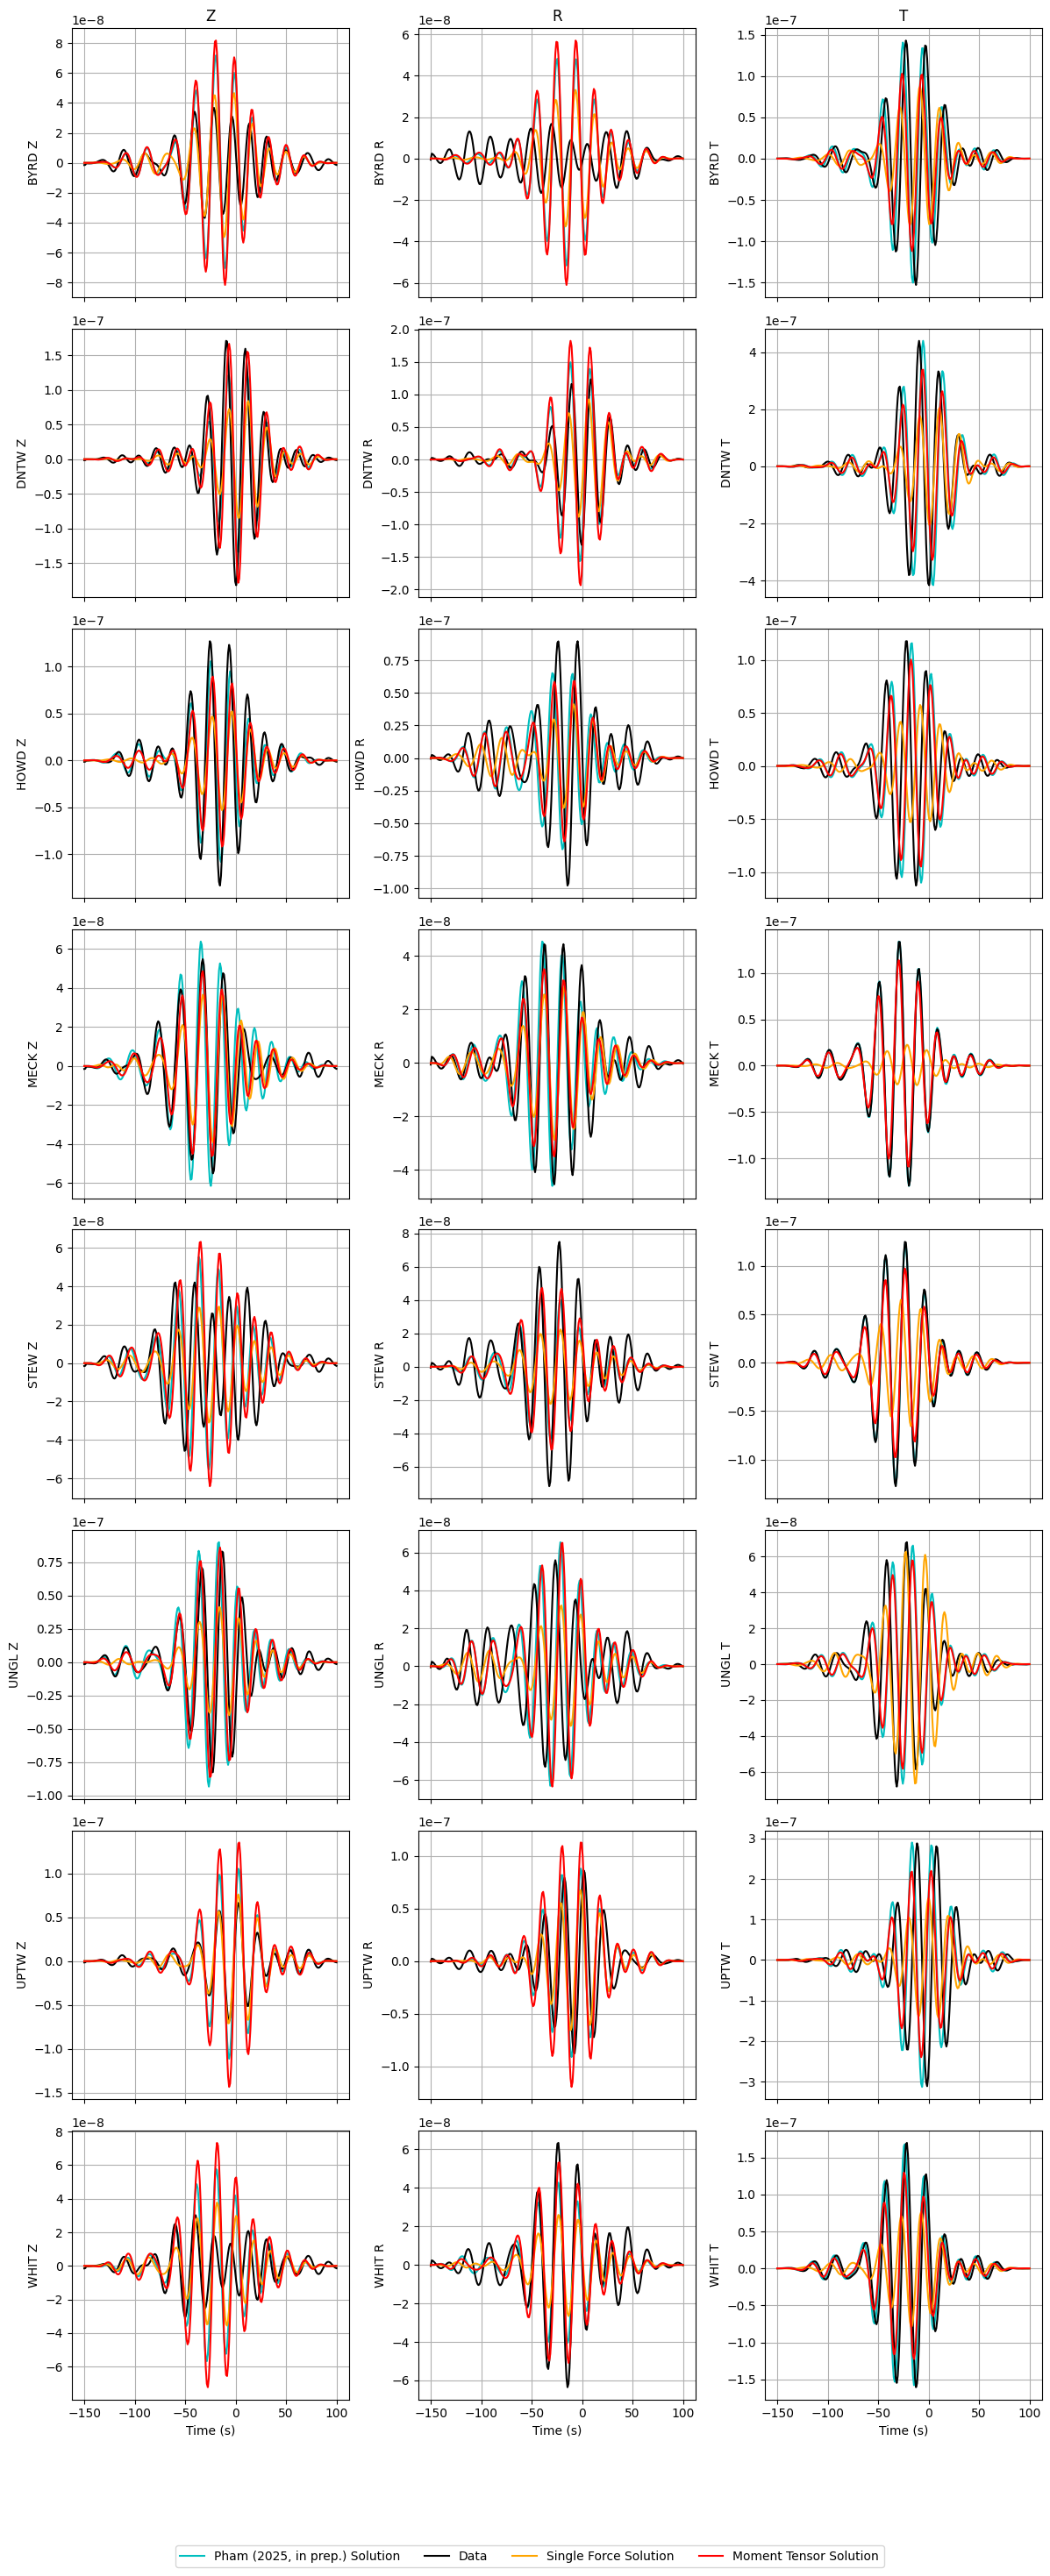

In [39]:
n_stations = len(stations)
fig_height = 3.5 * n_stations  # Adjust scaling as needed
fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True)

for i in range(n_stations):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[i, j]
        ax.plot(test_checker_x, SF_optimised_signals_son[i][j], c='c', label='Pham (2025, in prep.) Solution')
        ax.plot(test_checker_x, ydatas[i][:, j], c='k', label='Data')
        ax.plot(test_checker_x, SF_opt_signals_MAP[i][j], c='orange', label='Single Force Solution')
        # ax.plot(test_checker_x, SF_optimised_signals_v1[i][j], c='r', label='SF Optimised V1')
        ax.plot(test_checker_x, MT_opt_signals_MAP[i][j], c='r', label='Moment Tensor Solution')
        # ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), smoothed_Cd_z_symmetric_scaled if comp == 'Z' else smoothed_Cd_r_symmetric_scaled if comp == 'R' else smoothed_Cd_t_symmetric_scaled), c='cornflowerblue', label='Smoothed Symmetric Cov')

        ax.set_ylabel(f'{stations[i]} {comp}')
        if i == n_stations - 1:
            ax.set_xlabel('Time (s)')
        if i == 0:
            ax.set_title(comp)
        ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
        
# Get handles and labels from one of the axes (they should all be the same)
handles, labels = axes[0,0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# plt.suptitle('Trans-Conceptual Source Inversion (Thwaites 2018-11-08)', fontsize=16)
plt.tight_layout()

plt.show()

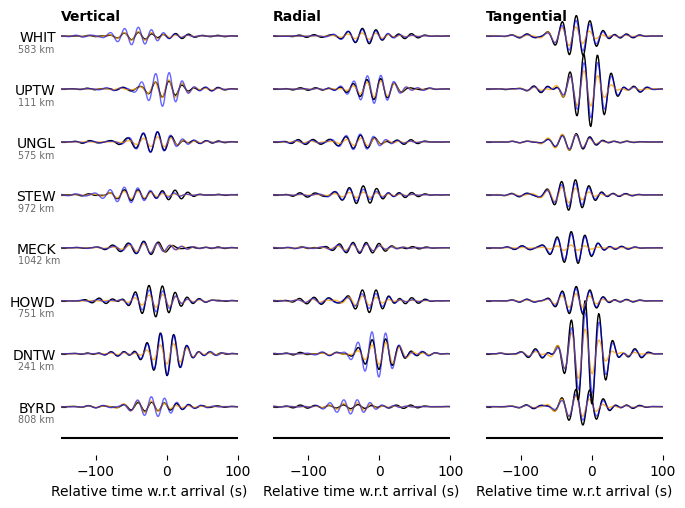

In [40]:
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(1, 3, bottom=0.05, top=0.95, left=0.08, right=0.94, wspace=0.2)
ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])]
scale = 1. / np.max(np.abs(ydatas))

distes = [808, 241, 751, 1042, 972, 575, 111, 583]

for j, comp in enumerate(['Z', 'R', 'T']):
    for i in range(len(stations)):
        ax[j].plot(test_checker_x, ydatas[i][:,j]*scale+i, c='k', lw=1)
        ax[j].plot(test_checker_x, model_sf[i][j]*scale+i, c='orange', alpha=0.8, lw=1)
        ax[j].plot(test_checker_x, model_mt[i][j]*scale+i, c='blue', lw=1, alpha=0.6)
        text = f'{distes[i]} km'
        if j == 0:
            ax[j].text(test_checker_x[0]-60, i-0.25, text, va='center', fontsize='x-small', color='dimgrey')
        
yt_positions = np.arange(len(stations))


for idx, x in enumerate(ax):
    x.tick_params(direction='in')
    x.set(xlabel='Relative time w.r.t arrival (s)')
    x.annotate(['Vertical', 'Radial', 'Tangential'][idx], xy=(0,1), xycoords='axes fraction', va='top', fontsize='medium', fontweight='bold')
    x.axhline(-0.6, 0, 1, lw=1.5, c='k')
    x.set(xlim=(-150, 100), ylim=(-1, len(stations)-0.5), yticks=[])
    # x.set_axis_off()
    # use numeric tick positions and hide labels except for left column
    x.set_yticks(yt_positions)
    if idx == 0:
        x.set_yticklabels(list(stations))
        x.yaxis.set_tick_params(labelleft=True)
    else:
        x.set_yticklabels([''] * len(stations))

    # remove frame lines
    for spine in x.spines.values():
        spine.set_visible(False)

fig.savefig('Synthetic_MT_realistic_waves.svg', bbox_inches='tight')

plt.show()

#         txt = f'$\\sigma$={tr.stats.snr:.1f}\n$\\tau$={tau:.0f}s\n$\\gamma$={vr*100:.0f}%'
#        ax[c].text(tvec[-1], s, txt, va='center', fontsize='x-small')

In [1]:
fig_height = 3.5  # Adjust scaling as needed
fig, axes = plt.subplots(1, 3, figsize=(12, fig_height), sharex=True, sharey=True)
noise_stat,noise_realization = 0,6

cdset = [C_ddz, C_ddr, C_ddt]
# noise = [low_amps_z,low_amps_r,low_amps_t]
#cdn = [cd_z,cd_r,cd_t]
# res = [res_z,res_r,res_t]
for i in range(1):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        ax.plot(test_checker_x, ydatas[0][:, j], c='k', label='Data')
        #ax.plot(time, ydatas[0][:, j]-res[j][0], c='r', label='SF Son et al. 2025')
        # ax.plot(time,res[j][0],c='k',lw=0.5)
        ax.plot(test_checker_x, residualss_sf[i][j], c='orange', label='SF Residuals')
        ax.plot(test_checker_x, residualss_mt[i][j], c='tab:blue', label='MT Residuals')
        # ax.plot(test_checker_x, residualss_son[i][j], c='c', ls='--', label='Son et al. 2025 Residuals')
        ax.plot(test_checker_x,np.random.multivariate_normal(np.zeros(250),cdset[j]),c='lightcoral', lw=0.8, label='Data Noise Realisation')
        if j == 0:
            ax.set_ylabel(f'Amplitude')
        ax.set_xlabel('Time (s)')
        # ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
        
# Get handles and labels from one of the axes (they should all be the same)
handles, labels = axes[0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# plt.suptitle('Synthetic Unrealistic Noise Random Noise Realization', fontsize=14)
plt.tight_layout()

fig.savefig('Synthetic_MT_realistic_noise.svg', bbox_inches='tight')
plt.show()    

NameError: name 'plt' is not defined